In [1]:
import jupyter_black
jupyter_black.load()

import warnings
warnings.filterwarnings('ignore')

These tutorials are written to help you get familiar with some of the common functionalities that most actuaries can use in their day-to-day responsibilities that are provided by the `chainladder` package. We will also be using the datasets that already come included with the package, allowing you to follow and reproduce the results as shown here.

Keep in mind that these tutorials were written to only demonstrate the functionalities of the package, and the user should always follow all applicable laws, the Code of Professional Conduct, applicable Actuarial Standards of Practice, and exercise their best actuarial judgement. These tutorials are not written in a way that encourage certain workflow, or recommendation, when it comes to analyzing a dataset or rendering an actuarial opinion.

The tutorials assume that you have the basic understanding of commonly used actuarial terms, and can independently perform an actuarial analysis in another tool, such as Microsoft Excel or another actuarial software. Furthermore, it is assumed that you already have some familiarity with Python, and that you have the basic knowledge and experience in using some common packages that are popular in the Python community, such as `pandas` and `numpy`.

All tutorials and exercises rely on `chainladder` v0.8.18 and later. If you have trouble reconciling the results from your workflow to this tutorial, you should verify the versions of the packages installed in your work environment and check the release notes in case updates patches are issued subsequently.

In [2]:
import pandas as pd
import numpy as np
import chainladder as cl

print("pandas: " + pd.__version__)
print("numpy: " + np.__version__)
print("chainladder: " + cl.__version__)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
pandas: 2.1.4
numpy: 1.26.3
chainladder: 0.8.18


# Working with Triangles

## Importing Data

Let's begin by looking at a raw triangle dataset and load it into a `pandas.DataFrame`. We'll use the data `raa`, which is available from the repository. Note that this dataset is currently in `csv` format.

In [3]:
raa_df = pd.read_csv(
    "https://raw.githubusercontent.com/casact/chainladder-python/master/chainladder/utils/data/raa.csv"
)
raa_df.head(20)

development  origin   values
0          1981    1981   5012.0
1          1982    1982    106.0
2          1983    1983   3410.0
3          1984    1984   5655.0
4          1985    1985   1092.0
5          1986    1986   1513.0
6          1987    1987    557.0
7          1988    1988   1351.0
8          1989    1989   3133.0
9          1990    1990   2063.0
10         1982    1981   8269.0
11         1983    1982   4285.0
12         1984    1983   8992.0
13         1985    1984  11555.0
14         1986    1985   9565.0
15         1987    1986   6445.0
16         1988    1987   4020.0
17         1989    1988   6947.0
18         1990    1989   5395.0
19         1983    1981  10907.0

The dataset has three columns: 
* development: or valuation time, in this case, the valuation year
* origin: or accident date, in this case, the accident year
* values: the values recorded for the specific accident date at the specific valuation time (such as incurred losses, paid losses, or claim counts), in this case, these are just "values" within the triangle, and has no specific metrics unit associated with them

A table of loss experience showing total losses for a certain period (origin) at various, regular valuation dates (development), reflects the change in amounts as claims mature and emerge. Older periods in the table will have one more entry than the next youngest period, leading to the triangle shape of the data in the table or any other measure that matures over time from an origin date. Loss triangles can be used to determine loss development for a given risk.

Let's put our data into the `chainladder.Triangle` format.

In [4]:
raa = cl.Triangle(
    data=raa_df,
    origin="origin",
    development="development",
    columns="values",
    cumulative=True,
)
raa

12       24       36       48       60       72       84       96       108      120
1981  5012.0   8269.0  10907.0  11805.0  13539.0  16181.0  18009.0  18608.0  18662.0  18834.0
1982   106.0   4285.0   5396.0  10666.0  13782.0  15599.0  15496.0  16169.0  16704.0      NaN
1983  3410.0   8992.0  13873.0  16141.0  18735.0  22214.0  22863.0  23466.0      NaN      NaN
1984  5655.0  11555.0  15766.0  21266.0  23425.0  26083.0  27067.0      NaN      NaN      NaN
1985  1092.0   9565.0  15836.0  22169.0  25955.0  26180.0      NaN      NaN      NaN      NaN
1986  1513.0   6445.0  11702.0  12935.0  15852.0      NaN      NaN      NaN      NaN      NaN
1987   557.0   4020.0  10946.0  12314.0      NaN      NaN      NaN      NaN      NaN      NaN
1988  1351.0   6947.0  13112.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN
1989  3133.0   5395.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN
1990  2063.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN

In the above example,
* `data` is the single `DataFrame` that contains columns representing all other arguments to the Triangle constructor. In our example, the dataset `raa_df`.
* `origin` is the representation of the accident, reporting or more generally the origin period of the triangle that will map to the `origin` dimension. In our example, the `origin` column
* `development` is the representation of the development/valuation periods of the triangle that will map to the `development` dimension. In our example, the `development` column.
* `columns` is the representation of the numeric data of the triangle that will map to the `columns` dimension. If `None`, then a single 'Total' key will be generated. In our example, the `values` column.
* `columuative` is the indicator of whether the triangle is cumulative or incremental. In our example, while it is not super obvious from looking at the raw data, our triangle dataset is actually a cumulative triangle. So we'll set this to `True`.
  
## Triangles Attributes

Now that we have our `Triangle` object declared within the `chainladder` package, we can get a lot of its attributes. First, let's get the latest diagonal of the Triangle with `.latest_diagonal`.

In [5]:
raa.latest_diagonal

1990
1981  18834.0
1982  16704.0
1983  23466.0
1984  27067.0
1985  26180.0
1986  15852.0
1987  12314.0
1988  13112.0
1989   5395.0
1990   2063.0

Another attribute that is commonly used is `.link_ratio` to get the LDFs of the triangle.

In [6]:
raa.link_ratio

12-24     24-36     36-48     48-60     60-72     72-84     84-96    96-108   108-120
1981   1.649840  1.319023  1.082332  1.146887  1.195140  1.112972  1.033261  1.002902  1.009217
1982  40.424528  1.259277  1.976649  1.292143  1.131839  0.993397  1.043431  1.033088       NaN
1983   2.636950  1.542816  1.163483  1.160709  1.185695  1.029216  1.026374       NaN       NaN
1984   2.043324  1.364431  1.348852  1.101524  1.113469  1.037726       NaN       NaN       NaN
1985   8.759158  1.655619  1.399912  1.170779  1.008669       NaN       NaN       NaN       NaN
1986   4.259749  1.815671  1.105367  1.225512       NaN       NaN       NaN       NaN       NaN
1987   7.217235  2.722886  1.124977       NaN       NaN       NaN       NaN       NaN       NaN
1988   5.142117  1.887433       NaN       NaN       NaN       NaN       NaN       NaN       NaN
1989   1.721992       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN

Another useful feature is the `.heatmap()` method.

In [7]:
raa.link_ratio.heatmap()

Here are some other attributes that might be useful to the user:
* `is_cumulative`: returns True if the data across the development periods is cumulative, or False if it is incremental.
* `is_ultimate`: returns True if the ultimate values are contained in the triangle.
* `is_val_tri`: returns True if the development period is stated as a valuation data as opposed to an age, i.e. Schedule P style triangle (True) or the more commonly used triangle by development age (False).
* `is_full`: returns True if the triangle has been "squared".

In [8]:
print("Is triangle cumulative?", raa.is_cumulative)
print("Does triangle contain ultimate projections?", raa.is_ultimate)
print("Is this a valuation triangle?", raa.is_val_tri)
print('Has the triangle been "squared"?', raa.is_full)

Is triangle cumulative? True
Does triangle contain ultimate projections? False
Is this a valuation triangle? False
Has the triangle been "squared"? False


We can also inspect the triangle to understand its data granularity with `origin_grain` and `development_grain`. The supported `grains` are:
* monthly: denoted with `M`
* quarterly: denoted with `Q`
* semi-annually: denoted with `S`
* annually: denoted with `Y`

In [9]:
print("Origin grain:", raa.origin_grain)
print("Development grain:", raa.development_grain)

Origin grain: Y
Development grain: Y


## Manipulating Triangles
There are also useful methods to convert an cumulative triangle into an incremental one with `.cum_to_incr()`.

In [10]:
raa.cum_to_incr()

12      24      36      48      60      72      84     96     108    120
1981  5012.0  3257.0  2638.0   898.0  1734.0  2642.0  1828.0  599.0   54.0  172.0
1982   106.0  4179.0  1111.0  5270.0  3116.0  1817.0  -103.0  673.0  535.0    NaN
1983  3410.0  5582.0  4881.0  2268.0  2594.0  3479.0   649.0  603.0    NaN    NaN
1984  5655.0  5900.0  4211.0  5500.0  2159.0  2658.0   984.0    NaN    NaN    NaN
1985  1092.0  8473.0  6271.0  6333.0  3786.0   225.0     NaN    NaN    NaN    NaN
1986  1513.0  4932.0  5257.0  1233.0  2917.0     NaN     NaN    NaN    NaN    NaN
1987   557.0  3463.0  6926.0  1368.0     NaN     NaN     NaN    NaN    NaN    NaN
1988  1351.0  5596.0  6165.0     NaN     NaN     NaN     NaN    NaN    NaN    NaN
1989  3133.0  2262.0     NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN
1990  2063.0     NaN     NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN

You can also convert an incremental triangle to a cumuative one with `.incr_to_cum()`.

In [11]:
raa.cum_to_incr().incr_to_cum()

12       24       36       48       60       72       84       96       108      120
1981  5012.0   8269.0  10907.0  11805.0  13539.0  16181.0  18009.0  18608.0  18662.0  18834.0
1982   106.0   4285.0   5396.0  10666.0  13782.0  15599.0  15496.0  16169.0  16704.0      NaN
1983  3410.0   8992.0  13873.0  16141.0  18735.0  22214.0  22863.0  23466.0      NaN      NaN
1984  5655.0  11555.0  15766.0  21266.0  23425.0  26083.0  27067.0      NaN      NaN      NaN
1985  1092.0   9565.0  15836.0  22169.0  25955.0  26180.0      NaN      NaN      NaN      NaN
1986  1513.0   6445.0  11702.0  12935.0  15852.0      NaN      NaN      NaN      NaN      NaN
1987   557.0   4020.0  10946.0  12314.0      NaN      NaN      NaN      NaN      NaN      NaN
1988  1351.0   6947.0  13112.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN
1989  3133.0   5395.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN
1990  2063.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN

Another useful one is to convert a development triangle to a valuation triangle (Schedule P style), with `.dev_to_val()`.

In [12]:
raa.dev_to_val()

1981    1982     1983     1984     1985     1986     1987     1988     1989     1990
1981  5012.0  8269.0  10907.0  11805.0  13539.0  16181.0  18009.0  18608.0  18662.0  18834.0
1982     NaN   106.0   4285.0   5396.0  10666.0  13782.0  15599.0  15496.0  16169.0  16704.0
1983     NaN     NaN   3410.0   8992.0  13873.0  16141.0  18735.0  22214.0  22863.0  23466.0
1984     NaN     NaN      NaN   5655.0  11555.0  15766.0  21266.0  23425.0  26083.0  27067.0
1985     NaN     NaN      NaN      NaN   1092.0   9565.0  15836.0  22169.0  25955.0  26180.0
1986     NaN     NaN      NaN      NaN      NaN   1513.0   6445.0  11702.0  12935.0  15852.0
1987     NaN     NaN      NaN      NaN      NaN      NaN    557.0   4020.0  10946.0  12314.0
1988     NaN     NaN      NaN      NaN      NaN      NaN      NaN   1351.0   6947.0  13112.0
1989     NaN     NaN      NaN      NaN      NaN      NaN      NaN      NaN   3133.0   5395.0
1990     NaN     NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   2063.0

And of course, you can convert it back with `.val_to_dev()`.

In [13]:
raa.dev_to_val().val_to_dev()

12       24       36       48       60       72       84       96       108      120
1981  5012.0   8269.0  10907.0  11805.0  13539.0  16181.0  18009.0  18608.0  18662.0  18834.0
1982   106.0   4285.0   5396.0  10666.0  13782.0  15599.0  15496.0  16169.0  16704.0      NaN
1983  3410.0   8992.0  13873.0  16141.0  18735.0  22214.0  22863.0  23466.0      NaN      NaN
1984  5655.0  11555.0  15766.0  21266.0  23425.0  26083.0  27067.0      NaN      NaN      NaN
1985  1092.0   9565.0  15836.0  22169.0  25955.0  26180.0      NaN      NaN      NaN      NaN
1986  1513.0   6445.0  11702.0  12935.0  15852.0      NaN      NaN      NaN      NaN      NaN
1987   557.0   4020.0  10946.0  12314.0      NaN      NaN      NaN      NaN      NaN      NaN
1988  1351.0   6947.0  13112.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN
1989  3133.0   5395.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN
1990  2063.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN

## 4-D Triangle

The triangle described so far is a two-dimensional (accident date by valuation date) structure that spans multiple cells of data. This is a useful structure for exploring individual triangles, but becomes more problematic when working with **sets** of triangles. `Pandas` does not have a triangle `dtype`, but if it did, working with sets of triangles would be much more convenient. To facilitate working with more than one triangle at a time,  `chainladder.Triangle` acts like a `pandas.DataFrame` (with an index and columns) where each cell (row x col) is an individual triangle. This structure manifests itself as a four-dimensional space. Let's take a look at another sample dataset, `clrd`.

In [14]:
clrd_df = pd.read_csv(
    "https://raw.githubusercontent.com/casact/chainladder-python/master/chainladder/utils/data/clrd.csv"
)
clrd_df.head()

GRCODE               GRNAME  AccidentYear  DevelopmentYear  DevelopmentLag  \
0      86  Allstate Ins Co Grp          1988             1988               1   
1      86  Allstate Ins Co Grp          1988             1989               2   
2      86  Allstate Ins Co Grp          1988             1990               3   
3      86  Allstate Ins Co Grp          1988             1991               4   
4      86  Allstate Ins Co Grp          1988             1992               5   

   IncurLoss  CumPaidLoss  BulkLoss  EarnedPremDIR  EarnedPremCeded  \
0     367404        70571    127737         400699             5957   
1     362988       155905     60173         400699             5957   
2     347288       220744     27763         400699             5957   
3     330648       251595     15280         400699             5957   
4     354690       274156     27689         400699             5957   

   EarnedPremNet  Single  PostedReserve97     LOB  
0         394742       0           281872  wkcomp  
1         394742       0           281872  wkcomp  
2         394742       0           281872  wkcomp  
3         394742       0           281872  wkcomp  
4         394742       0           281872  wkcomp

Let's load the data into the sets of triangles.

In [15]:
clrd = cl.Triangle(
    data=clrd_df,
    origin="AccidentYear",
    development="DevelopmentYear",
    columns=[
        "IncurLoss",
        "CumPaidLoss",
        "BulkLoss",
        "EarnedPremDIR",
        "EarnedPremCeded",
        "EarnedPremNet",
    ],
    index=["GRNAME", "LOB"],
    cumulative=True,
)
clrd

Triangle Summary
Valuation:                                            1997-12
Grain:                                                   OYDY
Shape:                                       (775, 6, 10, 10)
Index:                                          [GRNAME, LOB]
Columns:    [IncurLoss, CumPaidLoss, BulkLoss, EarnedPremD...

In this example, `data`, `origin`, `development`, and `cumulative` are all no different from what we had done before. But, we need to use `columns` a bit differently, and use declare a new variable, `index`.

* `columns` is the list of "triangles" metrics that we will have. Think of this as the type of triangle metrics that we can use to describe a segment. e.g. Paid, Incurred, Closed Claim counts, or even exposure data. Note that even exposure data do not develop over time, they can still be presented in a triangle format. In our example, `IncurLoss` for financial incurred loss (not just reported, as in paid + case + IBNR), `CumPaidLoss` for paid loss, `BulkLoss` for case reserves, `EarnedPremDIR` for direct and assumed premium earned, `EarnedPremCeded` for ceded premium earned, and `EarnedPremNet` for the net premium earned.
* `index` is our portfolio segments. In our example, a combination of `GRNAME`, the Company Name, and `LOB`, the line of business.

Since 4D structures do not fit nicely on 2D screens, we see a summary view instead that describes the structure rather than the underlying data itself. 

We see 5 rows of information:
* Valuation: the valuation date.
* Grain: the granularity of the data, `O` stands for origin, and `D` stands for development, `OYDY` represents triangles with accident year by development year.
* Shape: contains 4 numbers, represents the 4-D structure. This sample triangle represents a collection of 775x6 or 4,650 triangles that are themselves 10 accident years by 10 development periods.
    * 775: the number of segments, which is the combination of `index`, that represents the data segments. In this case, it is each of the `GRNAME` and `LOB` combination.
    * 6: the number of triangles for each segment, which is also the columns `[IncurLoss, CumPaidLoss, BulkLoss, EarnedPremDIR, EarnedPremCeded, EarnedPremNet]`.
    * 10: the number of accident periods.
    * 10: the number of valuation periods.
* Index: the segmentation level of the triangles.
* Columns: the value types recorded in the triangles.

Now we have a 4D triangle, let's do some `pandas`-style operations. First, we can filter.

In [16]:
clrd[clrd["LOB"] == "wkcomp"]

Triangle Summary
Valuation:                                            1997-12
Grain:                                                   OYDY
Shape:                                       (132, 6, 10, 10)
Index:                                          [GRNAME, LOB]
Columns:    [IncurLoss, CumPaidLoss, BulkLoss, EarnedPremD...

Note that only the shape changed, from `(775, 6, 10, 10)` to `(132, 6, 10, 10)`.

Next, you can use `.loc` to filter by index name.

In [17]:
clrd.loc["Allstate Ins Co Grp"]

Triangle Summary
Valuation:                                            1997-12
Grain:                                                   OYDY
Shape:                                         (2, 6, 10, 10)
Index:                                                  [LOB]
Columns:    [IncurLoss, CumPaidLoss, BulkLoss, EarnedPremD...

Let's see what LOB `Allstate Ins Co Grp` writes.

In [18]:
clrd.loc["Allstate Ins Co Grp"].index

LOB
0  prodliab
1    wkcomp

Since we have `.loc`, we must also have `.iloc` by index location. You can even chain them together. 

Let's get `Allstate Ins Co Grp`'s `prodliab` by calling `iloc[0]` and get the `CumPaidLoss` triangle.

In [19]:
clrd.loc["Allstate Ins Co Grp"].iloc[0]["CumPaidLoss"]

12       24       36       48       60       72       84       96       108      120
1988  1501.0   3916.0   8834.0  17450.0  22495.0  28687.0  31311.0  32039.0  36357.0  36358.0
1989  1697.0   5717.0  10442.0  18125.0  23284.0  30092.0  34338.0  41094.0  41164.0      NaN
1990  1373.0   4002.0  10829.0  16695.0  21788.0  25332.0  34875.0  34893.0      NaN      NaN
1991  1069.0   4594.0   6920.0   9996.0  13249.0  19221.0  19256.0      NaN      NaN      NaN
1992  1134.0   3068.0   5412.0   8210.0  19164.0  19187.0      NaN      NaN      NaN      NaN
1993   979.0   3079.0   6407.0  16113.0  16131.0      NaN      NaN      NaN      NaN      NaN
1994  1397.0   2990.0  25688.0  26030.0      NaN      NaN      NaN      NaN      NaN      NaN
1995  1016.0  21935.0  22095.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN
1996  9852.0  10071.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN
1997   319.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN

`iloc[...]` actually can take in 4 parameters, index, columns, origin, and development. For example, if we want `Allstate Ins Co Grp`'s `prodliab` index, we can search for it first, then call the indices of `CumPaidLoss`, and origin `1990`.

In [20]:
clrd.index[clrd.index["GRNAME"] == "Allstate Ins Co Grp"]

GRNAME       LOB
21  Allstate Ins Co Grp  prodliab
22  Allstate Ins Co Grp    wkcomp

In [21]:
clrd.iloc[21, 1, 2, :]

12      24       36       48       60       72       84       96   108  120
1990  1373.0  4002.0  10829.0  16695.0  21788.0  25332.0  34875.0  34893.0  NaN  NaN

We can also use other `pandas` filter functions, for example, getting the four `CumPaidLoss` diagonals between 1990 and 1993 wit hthe help of `.valuation`.

In [22]:
paid_tri = clrd.loc["Allstate Ins Co Grp"].iloc[0]["CumPaidLoss"]
paid_tri[(paid_tri.valuation >= "1990") & (paid_tri.valuation < "1994")]["CumPaidLoss"]

12      24       36       48       60       72
1988     NaN     NaN   8834.0  17450.0  22495.0  28687.0
1989     NaN  5717.0  10442.0  18125.0  23284.0      NaN
1990  1373.0  4002.0  10829.0  16695.0      NaN      NaN
1991  1069.0  4594.0   6920.0      NaN      NaN      NaN
1992  1134.0  3068.0      NaN      NaN      NaN      NaN
1993   979.0     NaN      NaN      NaN      NaN      NaN

Another commonly used filter is `.development`, let's get the three columns between age 36 and age 60.

In [23]:
paid_tri[(paid_tri.development >= 36) & (paid_tri.development <= 60)]

36       48       60
1988   8834.0  17450.0  22495.0
1989  10442.0  18125.0  23284.0
1990  10829.0  16695.0  21788.0
1991   6920.0   9996.0  13249.0
1992   5412.0   8210.0  19164.0
1993   6407.0  16113.0  16131.0
1994  25688.0  26030.0      NaN
1995  22095.0      NaN      NaN
1996      NaN      NaN      NaN
1997      NaN      NaN      NaN

With complete flexibility in the ability to slice subsets of triangles, we can use basic arithmetic to derive new triangles, which is commonly used as diagnostics to explore trends.

In [24]:
clrd["CaseIncurLoss"] = clrd["IncurLoss"] - clrd["BulkLoss"]
clrd["CaseIncurLoss"]

Triangle Summary
Valuation:           1997-12
Grain:                  OYDY
Shape:      (775, 1, 10, 10)
Index:         [GRNAME, LOB]
Columns:     [CaseIncurLoss]

Note that even though `clrd["CaseIncurLoss"]` is declared as a new variable, it actually comes with all 775 "indexes", i.e. we have 775 `clrd["CaseIncurLoss"]` triangles. But we can use `.sum()` to see the sum of them.

In [25]:
clrd["CaseIncurLoss"].sum()

12          24          36          48          60          72          84          96          108         120
1988   7778398.0   9872876.0  10537707.0  10973808.0  11175391.0  11265524.0  11288288.0  11305023.0  11323995.0  11327627.0
1989   8734319.0  10844720.0  11822136.0  12279311.0  12481505.0  12567543.0  12608487.0  12633539.0  12639258.0         NaN
1990   9325252.0  11913461.0  12985113.0  13459843.0  13646077.0  13718445.0  13755879.0  13768960.0         NaN         NaN
1991   9564486.0  12159826.0  13216383.0  13659541.0  13821032.0  13903084.0  13964163.0         NaN         NaN         NaN
1992  10539619.0  13125930.0  14120971.0  14563964.0  14755405.0  14850140.0         NaN         NaN         NaN         NaN
1993  11402448.0  14043343.0  15095232.0  15576086.0  15775057.0         NaN         NaN         NaN         NaN         NaN
1994  12411107.0  15005424.0  16095699.0  16650937.0         NaN         NaN         NaN         NaN         NaN         NaN
1995  12686394.0  15140099.0  16223016.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN
1996  12627293.0  14956778.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN
1997  12705993.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN

Let's look at the (sum of) Paid to (sum of) Incurred ratio triangle. Does it look like the ratios are changing over time? Using `.heatmap()` usually helps with spotting trends.

In [26]:
(clrd["CumPaidLoss"].sum() / clrd["CaseIncurLoss"].sum()).heatmap()

Compare the result to `(clrd["CumPaidLoss"] / clrd["CaseIncurLoss"]).sum()`, which looks odd, can you figure out why? This is because we are summing all of the quotients of paid losses over incurred losses at each index.

In [27]:
(clrd["CumPaidLoss"] / clrd["CaseIncurLoss"]).sum()

12          24          36          48          60          72          84          96          108        120
1988  183.174954  292.568472  331.870839  398.920441  494.883976  473.435946  485.361460  490.862840  489.800188  491.31401
1989  200.685859  303.319078  373.150572  420.302929  463.582968  484.426264  497.129633  505.378356  503.292688        NaN
1990  215.342110  369.604469  378.755996  476.510210  518.929698  505.843304  513.896098  520.722478         NaN        NaN
1991  164.685591  327.687927  396.143934  444.785517  485.415433  503.483137  514.193116         NaN         NaN        NaN
1992  218.254666  340.385259  411.630112  476.672321  499.918913  516.520918         NaN         NaN         NaN        NaN
1993  231.650900  352.995731  423.386563  483.572803  517.404169         NaN         NaN         NaN         NaN        NaN
1994  235.049595  355.944571  436.773937  498.180201         NaN         NaN         NaN         NaN         NaN        NaN
1995  235.370730  369.357522  445.787686         NaN         NaN         NaN         NaN         NaN         NaN        NaN
1996  245.990104  384.577758         NaN         NaN         NaN         NaN         NaN         NaN         NaN        NaN
1997  268.778113         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN        NaN

## Triangle Adjustments

Another adjustment we can make to the triangle is to apply a trend. We can do that by calling `chainladder.Trend()`, which is actually an estimator. It takes in a few variables:
- `trends`: the list containing the annual trends expressed as a decimal. For example, 5% decrease should be stated as -0.05.
- `dates`: a list-like of (start, end) dates to correspond to the trend list.
- `axis` (options: [‘origin’, ‘valuation’]): the axis on which to apply the trend.

Let's say we want a 5% trend from `1992-12-31` to `1991-01-01`. You can then call `.trend_` attribute to view the trend factors.

In [28]:
trend_factors = (
    cl.Trend(trends=[0.05], dates=[("1992-12-31", "1991-01-01")], axis="origin")
    .fit(clrd["CumPaidLoss"].sum())
    .trend_
)
trend_factors

12        24        36        48        60        72        84        96        108       120
1988  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027
1989  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027       NaN
1990  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027       NaN       NaN
1991  1.050000  1.050000  1.050000  1.050000  1.050000  1.050000  1.050000       NaN       NaN       NaN
1992  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000       NaN       NaN       NaN       NaN
1993  1.000000  1.000000  1.000000  1.000000  1.000000       NaN       NaN       NaN       NaN       NaN
1994  1.000000  1.000000  1.000000  1.000000       NaN       NaN       NaN       NaN       NaN       NaN
1995  1.000000  1.000000  1.000000       NaN       NaN       NaN       NaN       NaN       NaN       NaN
1996  1.000000  1.000000       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN
1997  1.000000       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN

Then we can apply the `trend_factors` to our loss triangle.

In [29]:
clrd["CumPaidLoss"].sum() * trend_factors

12            24            36            48            60            72            84            96            108           120
1988  3.928497e+06  7.752030e+06  9.691348e+06  1.082949e+07  1.150150e+07  1.187469e+07  1.207172e+07  1.217861e+07  1.226670e+07  1.230223e+07
1989  4.491675e+06  8.745454e+06  1.091166e+07  1.218654e+07  1.291992e+07  1.330675e+07  1.351849e+07  1.365377e+07  1.371753e+07           NaN
1990  5.027251e+06  9.671951e+06  1.206220e+07  1.342777e+07  1.414098e+07  1.453641e+07  1.477174e+07  1.488875e+07           NaN           NaN
1991  4.881194e+06  9.409843e+06  1.171196e+07  1.303007e+07  1.374664e+07  1.411986e+07  1.432453e+07           NaN           NaN           NaN
1992  5.139142e+06  9.757699e+06  1.202798e+07  1.328948e+07  1.399282e+07  1.434727e+07           NaN           NaN           NaN           NaN
1993  5.653379e+06  1.059942e+07  1.295381e+07  1.429252e+07  1.500514e+07           NaN           NaN           NaN           NaN           NaN
1994  6.246447e+06  1.139496e+07  1.384576e+07  1.524933e+07           NaN           NaN           NaN           NaN           NaN           NaN
1995  6.473843e+06  1.161215e+07  1.401010e+07           NaN           NaN           NaN           NaN           NaN           NaN           NaN
1996  6.591599e+06  1.147391e+07           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN
1997  6.451896e+06           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN

Multipart trend is also possible, since `trends` and `dates` can accept lists.

In [30]:
cl.Trend(
    trends=[0.05, -0.10],
    dates=[("1992-12-31", "1991-01-01"), ("1990-12-31", "1989-01-01")],
    axis="origin",
).fit(clrd["CumPaidLoss"].sum()).trend_

12        24        36        48        60        72        84        96        108       120
1988  0.897245  0.897245  0.897245  0.897245  0.897245  0.897245  0.897245  0.897245  0.897245  0.897245
1989  0.988224  0.988224  0.988224  0.988224  0.988224  0.988224  0.988224  0.988224  0.988224       NaN
1990  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027  1.098027       NaN       NaN
1991  1.050000  1.050000  1.050000  1.050000  1.050000  1.050000  1.050000       NaN       NaN       NaN
1992  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000       NaN       NaN       NaN       NaN
1993  1.000000  1.000000  1.000000  1.000000  1.000000       NaN       NaN       NaN       NaN       NaN
1994  1.000000  1.000000  1.000000  1.000000       NaN       NaN       NaN       NaN       NaN       NaN
1995  1.000000  1.000000  1.000000       NaN       NaN       NaN       NaN       NaN       NaN       NaN
1996  1.000000  1.000000       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN
1997  1.000000       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN

`chainladder.Triangle()` objects are awesome, but what if you need to get back out to `pandas`? `.to_frame()` is a very handy method to know. It converts the `chainladder.Triangle()` objects back to a `pandas.DataFrame()` object.

In [31]:
clrd["CumPaidLoss"].sum().to_frame()

12          24          36          48          60   \
1988-01-01  3577780.0   7059966.0   8826151.0   9862687.0  10474698.0   
1989-01-01  4090680.0   7964702.0   9937520.0  11098588.0  11766488.0   
1990-01-01  4578442.0   8808486.0  10985347.0  12229001.0  12878545.0   
1991-01-01  4648756.0   8961755.0  11154244.0  12409592.0  13092037.0   
1992-01-01  5139142.0   9757699.0  12027983.0  13289485.0  13992821.0   
1993-01-01  5653379.0  10599423.0  12953812.0  14292516.0  15005138.0   
1994-01-01  6246447.0  11394960.0  13845764.0  15249326.0         NaN   
1995-01-01  6473843.0  11612151.0  14010098.0         NaN         NaN   
1996-01-01  6591599.0  11473912.0         NaN         NaN         NaN   
1997-01-01  6451896.0         NaN         NaN         NaN         NaN   

                   72          84          96          108         120  
1988-01-01  10814576.0  10994014.0  11091363.0  11171590.0  11203949.0  
1989-01-01  12118790.0  12311629.0  12434826.0  12492899.0         NaN  
1990-01-01  13238667.0  13452993.0  13559557.0         NaN         NaN  
1991-01-01  13447481.0  13642414.0         NaN         NaN         NaN  
1992-01-01  14347271.0         NaN         NaN         NaN         NaN  
1993-01-01         NaN         NaN         NaN         NaN         NaN  
1994-01-01         NaN         NaN         NaN         NaN         NaN  
1995-01-01         NaN         NaN         NaN         NaN         NaN  
1996-01-01         NaN         NaN         NaN         NaN         NaN  
1997-01-01         NaN         NaN         NaN         NaN         NaN

Sometimes you just want the content copied to your clipboard, you can call `.to_clipboard()` and paste the result anywhere you like. 

In [32]:
clrd["CumPaidLoss"].sum().to_clipboard()

Other data I/O methods that you might want to know are `.to_json()` and `.to_pickle`. The inverse `chainladder.read_json()` and `chainladder.read_pickle()` are also available, but we won't explore them anymore here.

Now that we feel comfortable going in and out of `chainladder`, let's jump back in `chainladder` and explore some of the functions that an actuary often perform when working with triangles.

# Triangle Development

## Compute Loss Development Factors

Actuaries often spend lots of time trying to fine-tune their development factors, so let's explore the ways that `chainladder` can help us do that. `chainladder.Develompent()` is another helpful estimator, and has many useful attributes such as `.ldf_` or `.cdf_`.

Let's look at the dataset that we are already familiar with `clrd["CumPaidLoss"].sum()`.

In [33]:
cl.Development().fit(clrd["CumPaidLoss"].sum()).ldf_

12-24     24-36     36-48     48-60     60-72     72-84     84-96    96-108   108-120
(All)  1.86453  1.230856  1.109122  1.055039  1.028329  1.015751  1.008899  1.005879  1.002897

In [34]:
cl.Development().fit(clrd["CumPaidLoss"].sum()).cdf_

12-Ult   24-Ult    36-Ult    48-Ult    60-Ult  72-Ult    84-Ult    96-Ult   108-Ult
(All)  2.854913  1.53117  1.243988  1.121597  1.063086  1.0338  1.017769  1.008792  1.002897

Remember `incr_to_cum()` from earlier? It works with development factors too!

In [35]:
cl.Development().fit(clrd["CumPaidLoss"].sum()).ldf_.incr_to_cum()

12-Ult   24-Ult    36-Ult    48-Ult    60-Ult  72-Ult    84-Ult    96-Ult   108-Ult
(All)  2.854913  1.53117  1.243988  1.121597  1.063086  1.0338  1.017769  1.008792  1.002897

You may have noticed that these attributes have a trailing underscore (\_). This is scikit-learn’s API convention, as its documentation states, “attributes that have been estimated from the data must always have a name ending with trailing underscore”. For example, the coefficients of some regression estimator would be stored in a `coef_` attribute after fit has been called. In summary, the trailing underscore in class attributes is a scikit-learn’s convention to denote that the attributes are estimated, or to denote that they are fitted attributes.

Now, you might ask, how are the averages calculated? By default, `chainladder.Development()` calculates these averages using all data and volume average the factors. Note that since the `.average` attribute is not estimated, it has no underscore following it.

In [36]:
cl.Development().fit(clrd["CumPaidLoss"].sum()).average

'volume'

Other averaging methods are `simple` and `regression`. The OLS `regression` estimate of development factors where the regression equation is Y = mX + 0.

In [37]:
simple_ldf = cl.Development(average="simple").fit(clrd["CumPaidLoss"].sum()).ldf_
simple_ldf

12-24     24-36     36-48     48-60     60-72     72-84     84-96    96-108   108-120
(All)  1.878245  1.233252  1.109947  1.055521  1.028566  1.015797  1.008927  1.005952  1.002897

In [38]:
regression_ldf = (
    cl.Development(average="regression").fit(clrd["CumPaidLoss"].sum()).ldf_
)
regression_ldf

12-24     24-36     36-48     48-60     60-72     72-84     84-96    96-108   108-120
(All)  1.851565  1.228516  1.108323  1.054585  1.028105  1.015706  1.008867  1.005806  1.002897

Remember, you can do simple arithmetic with any Triangle object.

In [39]:
simple_ldf - regression_ldf

12-24     24-36     36-48     48-60     60-72     72-84    84-96    96-108  108-120
(All)  0.02668  0.004736  0.001624  0.000936  0.000461  0.000092  0.00006  0.000146      NaN

We can also vary the `average` used for each age-to-age factors. Here we have 9 age-to-age factors, so we can supply an array of averages to use. Here we set the averages to `volume`, `simple`, `regression`, `volume`, `simple`, `regression`, `volume`, `simple`, `regression` for 12-24, 24-36, etc, respectively.

In [40]:
cl.Development(average=["volume", "simple", "regression"] * 3).fit(
    clrd["CumPaidLoss"].sum()
).ldf_

12-24     24-36     36-48     48-60     60-72     72-84     84-96    96-108   108-120
(All)  1.86453  1.233252  1.108323  1.055039  1.028566  1.015706  1.008899  1.005952  1.002897

By default, `chainladder.Development()` sets `n_periods` as `-1` (use all data), which is the number of most recent periods to include in the calculation of averages. Let's try using only the most recent 3 periods.

In [41]:
cl.Development(average="simple", n_periods=3).fit(clrd["CumPaidLoss"].sum()).ldf_

12-24     24-36     36-48     48-60     60-72     72-84     84-96    96-108   108-120
(All)  1.786207  1.214568  1.103199  1.052592  1.026814  1.015533  1.008927  1.005952  1.002897

## Discarding Problematic Link Ratios

From time to time, there might be certain data points that we may want to exclude from the calculation of loss development factors. For example, let's say we want to discard valuation 1991 (the diagonal).

In [42]:
cl.Development(drop_valuation="1991").fit(clrd["CumPaidLoss"].sum()).ldf_

12-24     24-36     36-48     48-60     60-72     72-84     84-96    96-108   108-120
(All)  1.857588  1.228727  1.108023  1.053946  1.028329  1.015751  1.008899  1.005879  1.002897

Or that we want to drop a specific `origin` year's `age`.

In [43]:
cl.Development(drop=("1992", 24)).fit(clrd["CumPaidLoss"].sum()).ldf_

12-24    24-36     36-48     48-60     60-72     72-84     84-96    96-108   108-120
(All)  1.86453  1.23059  1.109122  1.055039  1.028329  1.015751  1.008899  1.005879  1.002897

Or calculating the averages using the Olympic Average method, discarding the highest or lowest, or the highest or lowest n factors.

In [44]:
cl.Development(drop_high=[True, True, False, True], drop_low=[1, 2, 0, 3]).fit(
    clrd["CumPaidLoss"].sum()
).ldf_

12-24     24-36     36-48     48-60     60-72     72-84     84-96    96-108   108-120
(All)  1.87613  1.237933  1.109122  1.057441  1.028329  1.015751  1.008899  1.005879  1.002897

## Setting Development Factors Manually

Sometimes, we want to manually set the age-to-age factors. `chainladder.DevelopmentConstant()` does exactly that. Note that we must also specify the `style` as `ldf` or `cdf`.

In [45]:
manual_patterns = {
    12: 1.8,
    24: 1.25,
    36: 1.10,
    48: 1.05,
    60: 1.03,
    72: 1.02,
    84: 1.01,
    96: 1.005,
    108: 1.002,
}
cl.DevelopmentConstant(patterns=manual_patterns, style="ldf").fit(
    clrd["CumPaidLoss"].sum()
).ldf_

12-24  24-36  36-48  48-60  60-72  72-84  84-96  96-108  108-120
(All)    1.8   1.25    1.1   1.05   1.03   1.02   1.01   1.005    1.002

Finally, before we go further, in `scikit-learn`, there are two types of estimators: transformers and predictors. A transformer transforms the input data (X) in some ways, and a predictor predicts a new value (or values, Y) by using the input data X.

`chainladder.Development()` and `chainladder.DevelopmentConstant()` are both transformers. The returned object is a means to create development patterns, which is used to estimate ultimates, but itself is not a IBNR estimation model, or a predictor.

In addition to `fit`, transformers come with the `transform` and `fit_transform` method. These will return a `chainladder.Triangle` object, but augment it with additional information for use in a subsequent IBNR model (a predictor). For example, `drop_high` can take an array of boolean variables, indicating if the highest factor should be dropped for each of the LDF calculation. 

Look at this example, calling `cl.Development().fit(clrd["CumPaidLoss"].sum()).ldf_` again actually doesn't give the transformed loss development factors that we had manually set, but using `fit_transform()` will actually modify the underlying attribute of the triangle, so we get the updated loss development factors.

In [46]:
cl.Development().fit(clrd["CumPaidLoss"].sum()).ldf_

12-24     24-36     36-48     48-60     60-72     72-84     84-96    96-108   108-120
(All)  1.86453  1.230856  1.109122  1.055039  1.028329  1.015751  1.008899  1.005879  1.002897

In [47]:
transformed_paid = cl.DevelopmentConstant(
    patterns=manual_patterns, style="ldf"
).fit_transform(clrd["CumPaidLoss"].sum())
transformed_paid.ldf_

12-24  24-36  36-48  48-60  60-72  72-84  84-96  96-108  108-120
(All)    1.8   1.25    1.1   1.05   1.03   1.02   1.01   1.005    1.002

One of the major benefits of `chainladder` is that it can handle several (or all) triangles simultaneously. While this can be a convenient shorthand, all these estimators will use the same assumptions across every triangle, as expected.

In [48]:
clrd_lob = cl.load_sample("clrd").groupby("LOB").sum()["CumPaidLoss"]
print("Fitting to " + str(len(clrd_lob.index)) + " industries simultaneously.")
cl.Development().fit_transform(clrd_lob).ldf_

Fitting to 6 industries simultaneously.


Triangle Summary
Valuation:          2261-12
Grain:                 OYDY
Shape:         (6, 1, 1, 9)
Index:                [LOB]
Columns:      [CumPaidLoss]

## Correlation Tests

`chainladder` also has functionality to tests for possible violation of assumptions. The two main tests are:

1. The `valuation_correlation` test:
    * This test tests for the assumption of independence of `origin` years. In fact, it tests for correlation across calendar periods (diagonals), and by extension, origin periods (rows).
    * An additional parameter, `total`, can be passed, depending on if we want to calculate valuation correlation in total across all origins (`True`), or for each origin separately (`False`).
    * The test uses Z-statistic.
2. The `development_correlation` test:
    * This test tests for the assumption of independence of the chain ladder method that assumes that subsequent development factors are not correlated (columns).
    * The test uses T-statistic.

In [49]:
print(
    "Are valuation years correlated? I.e., are origins years correlated?",
    clrd["CumPaidLoss"]
    .sum()
    .valuation_correlation(p_critical=0.1, total=True)
    .z_critical.values,
)
print(
    "Are development periods coorelated?",
    clrd["CumPaidLoss"].sum().development_correlation(p_critical=0.5).t_critical.values,
)

Are valuation years correlated? I.e., are origins years correlated? [[False]]
Are development periods coorelated? [[ True]]


# Extending Development Patterns with Tail

## Setting Tail Factors Manually

Often, a tail factor is necessary to supplement our loss development factors, since our triangle is too "small". `chainladder.TailConstant()` is a useful estimator that has `tail` and `decay` that allow us to fine-tune our fail factors.
* `tail`: The constant to apply to all LDFs within a triangle object.
* `decay`: An exponential decay constant that allows for decay over future development periods. A decay rate of 0.5 sets the development portion of each successive LDF to 50% of the previous LDF.

In [50]:
cl.TailConstant(tail=1.005, decay=0.50).fit(clrd["CumPaidLoss"].sum()).cdf_

12-Ult    24-Ult    36-Ult    48-Ult    60-Ult    72-Ult    84-Ult    96-Ult   108-Ult  120-Ult   132-Ult
(All)  2.869188  1.538826  1.250208  1.127205  1.068402  1.038969  1.022858  1.013836  1.007911    1.005  1.002504

In [51]:
cl.TailConstant(tail=1.005, decay=0.50).fit(
    clrd["CumPaidLoss"].sum()
).cdf_ / cl.Development().fit(clrd["CumPaidLoss"].sum()).cdf_

12-Ult  24-Ult  36-Ult  48-Ult  60-Ult  72-Ult  84-Ult  96-Ult  108-Ult  120-Ult  132-Ult
(All)   1.005   1.005   1.005   1.005   1.005   1.005   1.005   1.005    1.005      NaN      NaN

## Compute Tail Factors

`chainladder.TailCurve()` is another class of tail transformers. Similar to the `chainladder.Development()` or `chainladder.TailConstant()` estimator, it comes with `fit`, `transform` and `fit_transform` methods. Also, like our `chainladder.Development()` estimator, you can define a tail in the absence of data or if you believe development will continue beyond your latest evaluation period.

Here, we can extend our development factors from 120 months to 144 months. 

In [52]:
clrd["CumPaidLoss"].sum().development.max()

120

In [53]:
tail = cl.TailCurve()
tail.fit(clrd["CumPaidLoss"].sum()).ldf_

12-24     24-36     36-48     48-60     60-72     72-84     84-96    96-108   108-120   120-132   132-144
(All)  1.86453  1.230856  1.109122  1.055039  1.028329  1.015751  1.008899  1.005879  1.002897  1.001245  1.001311

These extra twelve months (144 - 120, or one year) of development patterns are included, as it is typical for actuaries to track IBNR run-off over a 1-year time horizon from the valuation date. The tail extension is currently fixed at one year and there is no ability to extend it even further. However, a subsequent version of `chainladder` may address this issue.

Curve fitting takes selected development patterns and extrapolates them using either an `exponential` or `inverse_power` fit. In most cases, the `inverse_power` produces a thicker (more conservative) tail.

In [54]:
exp = cl.TailCurve(curve="exponential").fit(clrd["CumPaidLoss"].sum())
exp.tail_

120-Ult
(All)  1.002558

In [55]:
inv_power = cl.TailCurve(curve="inverse_power").fit(clrd["CumPaidLoss"].sum())
inv_power.tail_

120-Ult
(All)  1.026366

When fitting a tail, by default, all of the data will be used; however, we can specify which period of development patterns we want to begin including in the curve fitting process with `fit_period`, which takes a tuple of `start` and `stop` period. `None` can be used to ignore `start` or `stop`. For example, `(48, None)` will use development factors for age 48 and beyond. Alternatively, passing a list of booleans `[True, False, …]` will allow for excluding (False) any development patterns from fitting.

Patterns will also be generated for 100 periods beyond the end of the triangle by default, or we can specify how far beyond the triangle to project the tail factor to before dropping the age-to-age factor down to 1.0 using `extrap_periods`.

Note that even though we can extrapolate the curve many years beyond the end of the triangle for computational purposes, the resultant development factors will compress all ldf_ beyond one year into a single age-ultimate factor.

Let's ignore the first 3 development patterns for curve fitting but including the rest. Let's also allow our tail extrapolation to go 50 periods beyond the end of the triangle. Note that both `fit_period` and `extrap_periods` follow the `development_grain` of the underlying triangle being fit.

In [56]:
cl.TailCurve(fit_period=(36, None), extrap_periods=50).fit(
    clrd["CumPaidLoss"].sum()
).ldf_

12-24     24-36     36-48     48-60     60-72     72-84     84-96    96-108   108-120   120-132   132-144
(All)  1.86453  1.230856  1.109122  1.055039  1.028329  1.015751  1.008899  1.005879  1.002897  1.001603  1.001996

# IBNR Models

## Chainladder Model

Now that we have set and transformed the triangles' loss development factors, the IBNR estimators are the final stage in analyzing reserve estimates in the `chainladder` package. These estimators have a `predict` method as opposed to a `transform` method.

The most popular method, the chainladder method, can be called with `chainladder.Chainladder()`. The basic chainladder method is entirely specified by its development pattern selections. For this reason, the `chainladder.Chainladder()` estimator takes no additional assumptions, i.e. no additional arguments is needed.

In [57]:
cl_mod = cl.Chainladder().fit(clrd["CumPaidLoss"].sum())
cl_mod

Chainladder()

All IBNR models come with common attributes. First, the `.ultimate_` attribute, which gives the ultimate estimates from using the underlying model.

In [58]:
cl_mod.ultimate_

2261
1988  1.120395e+07
1989  1.252909e+07
1990  1.367877e+07
1991  1.388483e+07
1992  1.483220e+07
1993  1.595176e+07
1994  1.710361e+07
1995  1.742840e+07
1996  1.756851e+07
1997  1.841960e+07

Note that ultimates are measured at a valuation date way into the future. The library is extraordinarily conservative in picking this date, and sets it to December 31, 2261. This is set globally and can be viewed by referencing the `ULT_VAL` constant. This is a very common maximum time value across multiple python packages and holds no additional meaning other than that is commonly chosen.

In [59]:
cl.options.get_option("ULT_VAL")

'2261-12-31 23:59:59.999999999'

If for some reason, year `2261` is not far enough out the future for you, you can change this to whatever value you like.

In [60]:
cl.options.set_option("ULT_VAL", "2050-12-31 23:59:59.999999999")
print(cl.options.get_option("ULT_VAL"))
cl.options.set_option("ULT_VAL", "2261-12-31 23:59:59.999999999")  # Resetting it back

2050-12-31 23:59:59.999999999


Another commonly used attribute that is shared across all models is the `.ibnr_` attribute, which is calculated as the difference between `.ultimate_` and `.latest_diagonal`.

In [61]:
cl_mod.ibnr_

2261
1988           NaN
1989  3.618623e+04
1990  1.192173e+05
1991  2.424152e+05
1992  4.849332e+05
1993  9.466176e+05
1994  1.854279e+06
1995  3.418299e+06
1996  6.094599e+06
1997  1.196771e+07

Other attributes that actuaries might be interested in are the `.full_triangle_` and `.full_expectation_` attributes. While the `.full_expectation_` is entirely based on `.ultimate_` values and development patterns, the `.full_triangle_` is a blend of the existing triangle. These are useful for conducting an analysis of actual results vs model expectations.

In [62]:
cl_mod.full_triangle_

12            24            36            48            60            72            84            96            108           120           132           9999
1988  3577780.0  7.059966e+06  8.826151e+06  9.862687e+06  1.047470e+07  1.081458e+07  1.099401e+07  1.109136e+07  1.117159e+07  1.120395e+07  1.120395e+07  1.120395e+07
1989  4090680.0  7.964702e+06  9.937520e+06  1.109859e+07  1.176649e+07  1.211879e+07  1.231163e+07  1.243483e+07  1.249290e+07  1.252909e+07  1.252909e+07  1.252909e+07
1990  4578442.0  8.808486e+06  1.098535e+07  1.222900e+07  1.287854e+07  1.323867e+07  1.345299e+07  1.355956e+07  1.363927e+07  1.367877e+07  1.367877e+07  1.367877e+07
1991  4648756.0  8.961755e+06  1.115424e+07  1.240959e+07  1.309204e+07  1.344748e+07  1.364241e+07  1.376382e+07  1.384473e+07  1.388483e+07  1.388483e+07  1.388483e+07
1992  5139142.0  9.757699e+06  1.202798e+07  1.328948e+07  1.399282e+07  1.434727e+07  1.457325e+07  1.470293e+07  1.478937e+07  1.483220e+07  1.483220e+07  1.483220e+07
1993  5653379.0  1.059942e+07  1.295381e+07  1.429252e+07  1.500514e+07  1.543022e+07  1.567325e+07  1.581273e+07  1.590568e+07  1.595176e+07  1.595176e+07  1.595176e+07
1994  6246447.0  1.139496e+07  1.384576e+07  1.524933e+07  1.608863e+07  1.654441e+07  1.680499e+07  1.695454e+07  1.705421e+07  1.710361e+07  1.710361e+07  1.710361e+07
1995  6473843.0  1.161215e+07  1.401010e+07  1.553891e+07  1.639415e+07  1.685858e+07  1.712411e+07  1.727650e+07  1.737806e+07  1.742840e+07  1.742840e+07  1.742840e+07
1996  6591599.0  1.147391e+07  1.412273e+07  1.566383e+07  1.652595e+07  1.699412e+07  1.726178e+07  1.741539e+07  1.751777e+07  1.756851e+07  1.756851e+07  1.756851e+07
1997  6451896.0  1.202976e+07  1.480689e+07  1.642265e+07  1.732654e+07  1.781738e+07  1.809801e+07  1.825907e+07  1.836640e+07  1.841960e+07  1.841960e+07  1.841960e+07

In [63]:
cl_mod.full_expectation_

12            24            36            48            60            72            84            96            108           120           132           9999
1988  3.924445e+06  7.317247e+06  9.006475e+06  9.989278e+06  1.053908e+07  1.083764e+07  1.100834e+07  1.110630e+07  1.117159e+07  1.120395e+07  1.120395e+07  1.120395e+07
1989  4.388605e+06  8.182687e+06  1.007171e+07  1.117075e+07  1.178558e+07  1.211945e+07  1.231034e+07  1.241989e+07  1.249290e+07  1.252909e+07  1.252909e+07  1.252909e+07
1990  4.791310e+06  8.933543e+06  1.099590e+07  1.219580e+07  1.286704e+07  1.323155e+07  1.343996e+07  1.355956e+07  1.363927e+07  1.367877e+07  1.367877e+07  1.367877e+07
1991  4.863486e+06  9.068117e+06  1.116154e+07  1.237951e+07  1.306087e+07  1.343087e+07  1.364241e+07  1.376382e+07  1.384473e+07  1.388483e+07  1.388483e+07  1.388483e+07
1992  5.195326e+06  9.686843e+06  1.192311e+07  1.322418e+07  1.395202e+07  1.434727e+07  1.457325e+07  1.470293e+07  1.478937e+07  1.483220e+07  1.483220e+07  1.483220e+07
1993  5.587475e+06  1.041802e+07  1.282308e+07  1.422235e+07  1.500514e+07  1.543022e+07  1.567325e+07  1.581273e+07  1.590568e+07  1.595176e+07  1.595176e+07  1.595176e+07
1994  5.990937e+06  1.117028e+07  1.374901e+07  1.524933e+07  1.608863e+07  1.654441e+07  1.680499e+07  1.695454e+07  1.705421e+07  1.710361e+07  1.710361e+07  1.710361e+07
1995  6.104703e+06  1.138240e+07  1.401010e+07  1.553891e+07  1.639415e+07  1.685858e+07  1.712411e+07  1.727650e+07  1.737806e+07  1.742840e+07  1.742840e+07  1.742840e+07
1996  6.153781e+06  1.147391e+07  1.412273e+07  1.566383e+07  1.652595e+07  1.699412e+07  1.726178e+07  1.741539e+07  1.751777e+07  1.756851e+07  1.756851e+07  1.756851e+07
1997  6.451896e+06  1.202976e+07  1.480689e+07  1.642265e+07  1.732654e+07  1.781738e+07  1.809801e+07  1.825907e+07  1.836640e+07  1.841960e+07  1.841960e+07  1.841960e+07

And of course, you can back test to see how close the actuals are compared to what the model thinks in the upper left side of our triangle.

In [64]:
residuals = cl_mod.full_expectation_ - cl_mod.full_triangle_
residuals[residuals.valuation < clrd.valuation_date]

12             24             36             48            60            72            84            96   108
1988  346664.831949  257280.559690  180324.113059  126591.261484  64380.299520  23064.221102  14325.313154  14937.996844  NaN
1989  297924.747991  217984.817928  134187.244310   72162.484363  19089.590029    661.634062  -1289.003906 -14937.996844  NaN
1990  212868.212760  125057.385629   10556.379469  -33204.396438 -11503.761841  -7114.895903 -13036.309247           NaN  NaN
1991  214729.726101  106361.821952    7299.869403  -30079.911240 -31168.757261 -16610.959261           NaN           NaN  NaN
1992   56183.954712  -70855.995074 -104876.441230  -65307.098905 -40797.370446           NaN           NaN           NaN  NaN
1993  -65904.023231 -181406.235367 -130736.003765  -70162.339263           NaN           NaN           NaN           NaN  NaN
1994 -255509.812661 -224675.692141  -96755.161245            NaN           NaN           NaN           NaN           NaN  NaN
1995 -369139.883519 -229746.662616            NaN            NaN           NaN           NaN           NaN           NaN  NaN
1996 -437817.754101            NaN            NaN            NaN           NaN           NaN           NaN           NaN  NaN

With this, we can also force the IBNR run-off of future periods, let's say we want the next three years'.

In [65]:
cl_mod.full_triangle_.dev_to_val().cum_to_incr().loc[..., "1998":"2000"]

1998          1999          2000
1988           NaN           NaN           NaN
1989  3.618623e+04           NaN           NaN
1990  7.971060e+04  3.950674e+04           NaN
1991  1.214019e+05  8.091135e+04  4.010186e+04
1992  2.259778e+05  1.296853e+05  8.643201e+04
1993  4.250811e+05  2.430349e+05  1.394741e+05
1994  8.393079e+05  4.557755e+05  2.605840e+05
1995  1.528808e+06  8.552461e+05  4.644305e+05
1996  2.648819e+06  1.541098e+06  8.621217e+05
1997  5.577860e+06  2.777139e+06  1.615756e+06

Most of the above methods from the `chainladder.Chainladder()` model apply to actuarial models inside `chainladder`, which we will not repeatedly demonstrate. 

Let's look at another model, the `chainladder.ExpectedLoss()` model, which is when we know the ultimate loss already (but then why would we estimate ultimate losses?). The Expected Loss model requires one input assumption, the `aprior`, which is a scalar multiplier that will be applied to an exposure vector, that will produce an a priori ultimate estimate vector that we can use for the model.

Let's assume that our `aprior` is 80% of the scalar multiplier, and that this multiplier should be applied to `clrd["EarnedPremDIR"]`. But first, let's revisit `clrd["EarnedPremDIR"].sum()`.

In [66]:
clrd["EarnedPremDIR"].sum()

12          24          36          48          60          72          84          96          108         120
1988  14759891.0  14759891.0  14759891.0  14759891.0  14759891.0  14759891.0  14759891.0  14759891.0  14759891.0  14759891.0
1989  16251494.0  16251494.0  16251494.0  16251494.0  16251494.0  16251494.0  16251494.0  16251494.0  16251494.0         NaN
1990  17967080.0  17967080.0  17967080.0  17967080.0  17967080.0  17967080.0  17967080.0  17967080.0         NaN         NaN
1991  19662971.0  19662971.0  19662971.0  19662971.0  19662971.0  19662971.0  19662971.0         NaN         NaN         NaN
1992  21208358.0  21208358.0  21208358.0  21208358.0  21208358.0  21208358.0         NaN         NaN         NaN         NaN
1993  22951940.0  22951940.0  22951940.0  22951940.0  22951940.0         NaN         NaN         NaN         NaN         NaN
1994  24758613.0  24758613.0  24758613.0  24758613.0         NaN         NaN         NaN         NaN         NaN         NaN
1995  26121518.0  26121518.0  26121518.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN
1996  26810956.0  26810956.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN
1997  27076444.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN

## Expected Loss Model

Remember that `chainladder.ExpectedLoss()` applies the scaler to a vector, and not a triangle. But we also see that the premium does not develop over time, so we can just get any vector we want. With that said, we will use the `.latest_diagonal` premium vector.

In [67]:
cl.ExpectedLoss(apriori=0.80).fit(
    clrd["CumPaidLoss"].sum(), sample_weight=clrd["EarnedPremDIR"].latest_diagonal.sum()
).ultimate_

2261
1988  11807912.8
1989  13001195.2
1990  14373664.0
1991  15730376.8
1992  16966686.4
1993  18361552.0
1994  19806890.4
1995  20897214.4
1996  21448764.8
1997  21661155.2

A very common question that one might ask is what is the difference between:

```python
cl.ExpectedLoss(apriori=0.80).fit(..., sample_weight=weight_vector)
```

versus 

```python
cl.ExpectedLoss(apriori=1.00).fit(..., sample_weight=weight_vector*0.80)
```

Here is where `chainladder` follows `scikit-learn`'s implementation philosophy closely. The `apriori=...` inside the estimator, `chainladder.ExpectedLoss()` is a model parameter, whereas the inputs inside `fit()` are the data that the model will be applied to. With that said, only the first code block's syntax is theoretically correct, because in the second scenario, we are technically modifying our data, while not using the model assumption (i.e. `apriori`) correctly, even though they will yield identical results.

Let's apply the same model to `clrd["IncurLoss"].sum()` just to make sure that we get the exact same ultimates.

In [68]:
cl.ExpectedLoss(apriori=0.80).fit(
    clrd["IncurLoss"].sum(), sample_weight=clrd["EarnedPremDIR"].latest_diagonal.sum()
).ultimate_

2261
1988  11807912.8
1989  13001195.2
1990  14373664.0
1991  15730376.8
1992  16966686.4
1993  18361552.0
1994  19806890.4
1995  20897214.4
1996  21448764.8
1997  21661155.2

## Bornhuetter-Ferguson

The `chainladder.BornhuetterFerguson()` estimator is another method having many of the same attributes as the `chainladder.Chainladder()` estimator. It comes with one input assumption, the a priori (`apriori`), a scalar multiplier that will be applied to an exposure vector, which will produce an a priori ultimate estimate vector that we can use for the model, which works exactly like `chainladder.ExpectedLoss()`.

In [69]:
cl.BornhuetterFerguson(apriori=0.80).fit(
    clrd["CumPaidLoss"].sum(), sample_weight=clrd["EarnedPremDIR"].latest_diagonal.sum()
).ultimate_

2261
1988  1.120395e+07
1989  1.253045e+07
1990  1.368483e+07
1991  1.391705e+07
1992  1.490199e+07
1993  1.609476e+07
1994  1.739668e+07
1995  1.810875e+07
1996  1.891459e+07
1997  2.052573e+07

## Benktander

The `chainladder.Benktander()` method is similar to the Bornhuetter-Ferguson method, but allows for the specification of one additional assumption, `n_iters`, the number of iterations to recalculate the ultimates. The Benktander method generalizes both the Bornhuetter-Ferguson and the Chainladder estimator through this assumption.

- When `n_iters = 1`, the result is equivalent to the Bornhuetter-Ferguson estimator.
- When `n_iters` is sufficiently large, the result converges to the Chainladder estimator.

Let's try with `n_iters = 1`, the result is the same as Bornhuetter-Ferguson's estimate.

In [70]:
cl.Benktander(apriori=0.80, n_iters=1).fit(
    clrd["CumPaidLoss"].sum(), sample_weight=clrd["EarnedPremDIR"].latest_diagonal.sum()
).ultimate_

2261
1988  1.120395e+07
1989  1.253045e+07
1990  1.368483e+07
1991  1.391705e+07
1992  1.490199e+07
1993  1.609476e+07
1994  1.739668e+07
1995  1.810875e+07
1996  1.891459e+07
1997  2.052573e+07

Now `n_iters` sufficiently large, like 100, the result is (nearly) the same as Chainladder's estimate.

In [71]:
cl.Benktander(apriori=0.80, n_iters=100).fit(
    clrd["CumPaidLoss"].sum(), sample_weight=clrd["EarnedPremDIR"].latest_diagonal.sum()
).ultimate_

2261
1988  1.120395e+07
1989  1.252909e+07
1990  1.367877e+07
1991  1.388483e+07
1992  1.483220e+07
1993  1.595176e+07
1994  1.710361e+07
1995  1.742840e+07
1996  1.756851e+07
1997  1.841960e+07

## Cape Cod

The `chainladder.CapeCod()` method is similar to the Bornhuetter-Ferguson method, except its a priori is computed from the Triangle itself. Instead of specifying an a priori, `decay` and `trend` need to be specified.

- `decay` is the rate that gives weights to earlier origin periods, this parameter is required by the Generalized Cape Cod Method, as discussed in Using Best Practices to Determine a Best Reserve Estimate by Struzzieri and Hussian.
    - As the `decay` factor approaches 1 (the default value), the result approaches the traditional Cape Cod method.
    - As the decay factor approaches 0, the result approaches the Chainladder method.
- `trend` is the trend rate along the origin axis to reflect systematic inflationary impacts on the a priori.

When we fit a Cape Cod method, we can see the a priori it computes with the given decay and trend assumptions. Since it is an array of estimated parameters, this CapeCod attribute is called the apriori_, with a trailing underscore.

In [72]:
cl.CapeCod().fit(
    clrd["CumPaidLoss"].sum(), sample_weight=clrd["EarnedPremDIR"].latest_diagonal.sum()
).apriori_

2261
1988  0.706934
1989  0.706934
1990  0.706934
1991  0.706934
1992  0.706934
1993  0.706934
1994  0.706934
1995  0.706934
1996  0.706934
1997  0.706934

With `decay=0`, the `.apriori_` for each origin period gets their unique apriori.

In [73]:
cl.CapeCod(decay=0).fit(
    clrd["CumPaidLoss"].sum(), sample_weight=clrd["EarnedPremDIR"].latest_diagonal.sum()
).apriori_

2261
1988  0.759081
1989  0.770950
1990  0.761324
1991  0.706141
1992  0.699357
1993  0.695007
1994  0.690814
1995  0.667205
1996  0.655274
1997  0.680281

And we can apply `trend`, of say -1% annually, to further fine-tune the a prioris.

In [74]:
cl.CapeCod(decay=0, trend=-0.01).fit(
    clrd["CumPaidLoss"].sum(), sample_weight=clrd["EarnedPremDIR"].latest_diagonal.sum()
).apriori_

2261
1988  0.693433
1989  0.711390
1990  0.709604
1991  0.664818
1992  0.665081
1993  0.667621
1994  0.670296
1995  0.653927
1996  0.648721
1997  0.680281

You can also view the trended aprioris without the trend with `.detrended_apriori_`.

In [75]:
cl.CapeCod(decay=0, trend=-0.01).fit(
    clrd["CumPaidLoss"].sum(), sample_weight=clrd["EarnedPremDIR"].latest_diagonal.sum()
).detrended_apriori_

2261
1988  0.759081
1989  0.770950
1990  0.761324
1991  0.706141
1992  0.699357
1993  0.695007
1994  0.690814
1995  0.667205
1996  0.655274
1997  0.680281

## Workflow Pipelines

All the deterministic estimators have `.ultimate_`, `.ibnr_`, `.full_expecation_` and `.full_triangle_` attributes that are themselves `chainladder.Triangle`s. These can be manipulated in a variety of ways to gain additional insights from our model. 

Furthermore, these estimators work very well with the transformers discussed in previously. Let’s look at the compositional nature of these estimators and how `chainladder.Pipeline()` can chain multiple operations together quickly. Recall the dataset that we've been working with, but grouping the dataset at the line of business (`LOB`) level.

In [76]:
clrd_lob = clrd.groupby("LOB").sum()
clrd_lob

Triangle Summary
Valuation:                                            1997-12
Grain:                                                   OYDY
Shape:                                         (6, 7, 10, 10)
Index:                                                  [LOB]
Columns:    [IncurLoss, CumPaidLoss, BulkLoss, EarnedPremD...

In [77]:
clrd_lob["IncurLoss"].sum()

12          24          36          48          60          72          84          96          108         120
1988  11644995.0  11674240.0  11653597.0  11630882.0  11593868.0  11551625.0  11463312.0  11420238.0  11415560.0  11396981.0
1989  13123290.0  13118789.0  13113024.0  13050144.0  12959037.0  12866709.0  12787372.0  12757420.0  12743440.0         NaN
1990  14776079.0  14670690.0  14479699.0  14324680.0  14183178.0  14033498.0  13948139.0  13925679.0         NaN         NaN
1991  15318373.0  15112547.0  14877662.0  14615540.0  14380205.0  14205778.0  14154882.0         NaN         NaN         NaN
1992  16828857.0  16457307.0  15999385.0  15538214.0  15249286.0  15161066.0         NaN         NaN         NaN         NaN
1993  18169370.0  17590902.0  17080187.0  16485467.0  16281774.0         NaN         NaN         NaN         NaN         NaN
1994  19414898.0  18609089.0  17854178.0  17521037.0         NaN         NaN         NaN         NaN         NaN         NaN
1995  19502850.0  18668388.0  17901550.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN
1996  19142090.0  17910743.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN
1997  18113581.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN

Since we have many sets of 10x10 triangles, we can apply a "selected" set of development patterns to all of them, say we want to:
- Drop the 1991 valuation period.
- Use `volume`-weighted for the first 5 factors, and `simple` average for the next 4 factors.
- Use no more than 7 periods.
- Use the `inverse_power` curve and extrapolate 80 periods in the tail.

In [78]:
patterns = cl.Pipeline(
    [
        (
            "dev",
            cl.Development(
                average=["volume"] * 5 + ["simple"] * 4,
                n_periods=7,
                drop_valuation="1995",
            ),
        ),
        ("tail", cl.TailCurve(curve="inverse_power", extrap_periods=80)),
    ]
)

We now have 6 LOBs and each with 7 columns (`IncurLoss`, `CumPaidLoss`, `BulkLoss`, `EarnedPremDIR`, `EarnedPremCeded`, `EarnedPremNet`, and `CaseIncurLoss`.

Let's fit a Cape Cod model to all the `IncurLoss` triangles.

In [79]:
incurred_lob = cl.CapeCod(decay=0, trend=-0.01).fit(
    X=patterns.fit_transform(clrd_lob["IncurLoss"]),
    sample_weight=clrd_lob["EarnedPremNet"].latest_diagonal,
)

And now we can call each LOB's incurred ultimate easily. This vastly simplified our workflow.

In [80]:
clrd_lob.index

LOB
0   comauto
1    medmal
2   othliab
3    ppauto
4  prodliab
5    wkcomp

In [81]:
clrd_lob.index
incurred_lob.ultimate_.loc["othliab", :, :, :]

2261
1988  328473.000000
1989  367994.093378
1990  397774.260542
1991  485918.271360
1992  501166.803876
1993  568930.997730
1994  647890.072761
1995  610951.931101
1996  679568.821347
1997  669403.512799

## Voting Chainladder

Actuaries often don't rely on a single model, but a combination of models and they will weight in each of their pros and cons. `chainlaader.VotingChainladder()` is an ensemble meta-estimator, that works taking in a matrix of weights to form a final ultimate estimate. Let's see how it works.

First, we begin by declaring a bunch of models that we want, note that none of the data is passed in. This is the beauty of seperating model and data.

In [82]:
cl_mod = cl.Chainladder()
el_mod = cl.ExpectedLoss(apriori=0.8)
bf_mod = cl.BornhuetterFerguson(apriori=0.8)
cc_mod = cl.CapeCod(decay=1, trend=0.05)
bk_mod = cl.Benktander(apriori=0.8, n_iters=2)

Next, we need to prepare the `estimators` variable. This `estimators` parameter in `chainladder.VotingChainladder()` must be in an array of tuples, with (estimator_name, estimator) pairing.

In [83]:
estimators = [
    ("cl", cl_mod),
    ("el", el_mod),
    ("bf", bf_mod),
    ("cc", cc_mod),
    ("bk", bk_mod),
]

Now, let's bring in the data.

Recall that some estimators (in this case, `chainladder.BornhuetterFerguson()`, `chainladder.CapeCod()`, and `chainladder.Benktander()`) require the variable `sample_weight`, let's set that up.

In [84]:
sample_weight = clrd["EarnedPremNet"].sum().latest_diagonal
sample_weight

1997
1988  13861176.0
1989  15227729.0
1990  16782295.0
1991  18305690.0
1992  19802657.0
1993  21372028.0
1994  23057846.0
1995  24420839.0
1996  25020256.0
1997  25281654.0

Finally, we are ready to fit the data into various models, and applying the weights based on `origin` years.

In [85]:
model_weights = np.array(
    [[0.6, 0.0, 0.2, 0.2, 0.0]] * 4
    + [[0.0, 0.0, 0.5, 0.5, 0.0]] * 3
    + [[0.0, 0.0, 0.0, 1.0, 0.0]] * 3
)

vot_mod = cl.VotingChainladder(estimators=estimators, weights=model_weights).fit(
    clrd["IncurLoss"].sum(), sample_weight=sample_weight
)
vot_mod.ultimate_

2261
1988  1.139698e+07
1989  1.272397e+07
1990  1.389398e+07
1991  1.408674e+07
1992  1.500015e+07
1993  1.596923e+07
1994  1.695629e+07
1995  1.689904e+07
1996  1.628831e+07
1997  1.568687e+07

`chainladder.VotingChainladder()` has an additional attribute, `weights` that shows the weight matrix that is applied.

In [86]:
vot_mod.weights

array([[0.6, 0. , 0.2, 0.2, 0. ],
       [0.6, 0. , 0.2, 0.2, 0. ],
       [0.6, 0. , 0.2, 0.2, 0. ],
       [0.6, 0. , 0.2, 0.2, 0. ],
       [0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. , 0. ]])

Let's make a graph to wrap everything up, comparing all of the model's estimates vs what we have selected in `chainladder.VotingChainladder()`.

We will leave it up to the reader to clean up the axis in the graph.

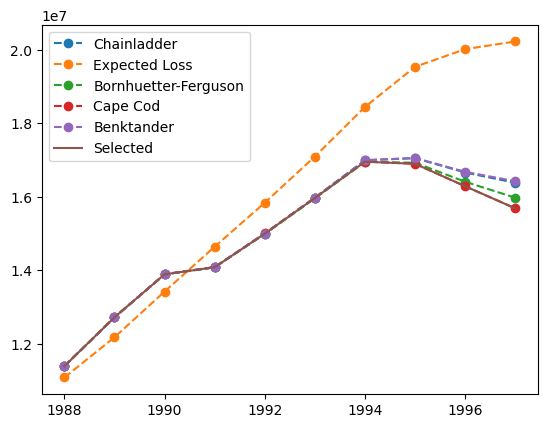

In [87]:
loss_data = clrd["IncurLoss"].sum()

import matplotlib.pyplot as plt

plt.plot(
    cl_mod.fit(loss_data).ultimate_.to_frame(origin_as_datetime=True).index.year,
    cl_mod.fit(loss_data).ultimate_.to_frame(origin_as_datetime=True),
    label="Chainladder",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    el_mod.fit(loss_data, sample_weight=sample_weight)
    .ultimate_.to_frame(origin_as_datetime=True)
    .index.year,
    el_mod.fit(loss_data, sample_weight=sample_weight).ultimate_.to_frame(
        origin_as_datetime=True
    ),
    label="Expected Loss",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    bf_mod.fit(loss_data, sample_weight=sample_weight)
    .ultimate_.to_frame(origin_as_datetime=True)
    .index.year,
    bf_mod.fit(loss_data, sample_weight=sample_weight).ultimate_.to_frame(
        origin_as_datetime=True
    ),
    label="Bornhuetter-Ferguson",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    cc_mod.fit(loss_data, sample_weight=sample_weight)
    .ultimate_.to_frame(origin_as_datetime=True)
    .index.year,
    cc_mod.fit(loss_data, sample_weight=sample_weight).ultimate_.to_frame(
        origin_as_datetime=True
    ),
    label="Cape Cod",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    bk_mod.fit(loss_data, sample_weight=sample_weight)
    .ultimate_.to_frame(origin_as_datetime=True)
    .index.year,
    bk_mod.fit(loss_data, sample_weight=sample_weight).ultimate_.to_frame(
        origin_as_datetime=True
    ),
    label="Benktander",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    vot_mod.ultimate_.to_frame(origin_as_datetime=True).index.year,
    vot_mod.ultimate_.to_frame(origin_as_datetime=True),
    label="Selected",
)
plt.legend(loc="best")

Note that it is not possible to use `chainladder.VotingChainladder()` with multiple datasets. For example, blending the ultimate estimate using paid data and the ultimate estimate using incurred data. This strictly follow `scikit-learn` and its model and data implementation philosophy.

## MackChainladder

Now that we know how to run deterministic models from `chainladder`, `chainladder` also has stochastic models.

Like the basic Chainladder method, the `chainladder.MackChainladder()` is entirely specified by its selected development pattern. In fact, it is the basic Chainladder model, but with extra features.

In [88]:
cl.Chainladder().fit(clrd["CumPaidLoss"].sum()).ultimate_ == cl.MackChainladder().fit(
    clrd["CumPaidLoss"].sum()
).ultimate_

True

Let's store the model result as `mack_mod` and look at its additional attributes.

In [89]:
mack_mod = cl.MackChainladder().fit(clrd["CumPaidLoss"].sum())
mack_mod

MackChainladder()

`chainladder.MackChainladder()` has the following additional fitted features that the deterministic `chainladder.Chainladder()` does not:
- `full_std_err_`: The full standard error.
- `total_process_risk_`: The total process error.
- `total_parameter_risk_`: The total parameter error.
- `mack_std_err_`: The total prediction error by `origin` period.
- `total_mack_std_err_`: The total prediction error across all `origin` periods.

In [90]:
mack_mod.mack_std_err_

12             24             36             48             60             72             84             96             108            120            9999
1988   NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN
1989   NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN    7612.690223    7612.690223
1990   NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN   28691.407720   29904.992210   29904.992210
1991   NaN            NaN            NaN            NaN            NaN            NaN            NaN   16178.602115   33242.040280   34341.474494   34341.474494
1992   NaN            NaN            NaN            NaN            NaN            NaN   13979.389430   21992.890793   37543.594231   38638.874014   38638.874014
1993   NaN            NaN            NaN            NaN            NaN   40597.438138   43751.707004   47552.710115   57499.871103   58393.849416   58393.849416
1994   NaN            NaN            NaN            NaN   68320.462843   82023.501630   84702.714537   87438.353020   94123.060189   94894.193048   94894.193048
1995   NaN            NaN            NaN   90704.313340  118024.302156  128698.338240  131635.018550  134122.292695  139121.818776  139872.884208  139872.884208
1996   NaN            NaN  191747.066733  231370.426260  253779.828508  264491.695092  269105.844778  272153.518557  275877.015450  276854.086589  276854.086589
1997   NaN  483823.825083  627242.770754  701962.818458  744029.006561  766386.657312  778622.006993  785791.370313  791200.371859  793559.126941  793559.126941

Notice these are all measures of uncertainty, and can be extremely useful when you want to run various triangle diagnostics.

Let’s start by examining the link_ratios underlying the triangle between age 12 and 24.

In [91]:
clrd_first_lag = clrd[clrd.development <= 24][clrd.origin < "1997"]["CumPaidLoss"].sum()
clrd_first_lag

12          24
1988  3577780.0   7059966.0
1989  4090680.0   7964702.0
1990  4578442.0   8808486.0
1991  4648756.0   8961755.0
1992  5139142.0   9757699.0
1993  5653379.0  10599423.0
1994  6246447.0  11394960.0
1995  6473843.0  11612151.0
1996  6591599.0  11473912.0

A simple average link-ratio can be directly computed.

In [92]:
clrd_first_lag.link_ratio.to_frame().mean()[0]

1.8782447151772095

Which can be verified with the `chainladder.Development()` object, ignoring the very minor rounding difference.

In [93]:
cl.Development(average="simple").fit(clrd["CumPaidLoss"].sum()).ldf_.to_frame().iloc[
    0, 0
]

1.8782447151772093

### Linear Regression Framework

Mack noted that the estimate for the LDF is really just a linear regression fit. In the case of using the simple average, it is a weighted regression where the weight is $\left (\frac{1}{X} \right )^{2}$.

Let’s take a look at the fitted coefficient and verify that this ties to the direct calculations that we made earlier. With the regression framework in hand, we can get more information about our LDF estimate than just the coefficient.

In [94]:
import statsmodels.api as sm

y = clrd_first_lag.to_frame(origin_as_datetime=True).values[:, 1]
x = clrd_first_lag.to_frame(origin_as_datetime=True).values[:, 0]

sm.WLS(y, x, weights=(1 / x) ** 2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            WLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              5323.
Date:                Wed, 03 Apr 2024   Prob (F-statistic):                    1.39e-12
Time:                        13:54:20   Log-Likelihood:                         -128.23
No. Observations:                   9   AIC:                                      258.5
Df Residuals:                       8   BIC:                                      258.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8782      0.026     72.958      0.000       1.819       1.938
==============================================================================
Omnibus:                        1.016   Durbin-Watson:                   0.188
Prob(Omnibus):                  0.602   Jarque-Bera (JB):                0.777
Skew:                          -0.563   Prob(JB):                        0.678
Kurtosis:                       2.103   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

By toggling the weights of our regression, we can handle the most common types of averaging used in picking loss development factors.

- For simple average, the weights are $\left (\frac{1}{X} \right )^{2}$
- For volume-weighted average, the weights are $\left (\frac{1}{X} \right )$
- For “regression” average, the weights are 1

Let's check to see if everything reconciles.

In [95]:
print(
    "Simple average:",
    round(
        cl.Development(average="simple")
        .fit(clrd_first_lag)
        .ldf_.to_frame(origin_as_datetime=False)
        .values[0, 0],
        10,
    )
    == round(sm.WLS(y, x, weights=(1 / x) ** 2).fit().params[0], 10),
)

print(
    "Volume-weighted average:",
    round(
        cl.Development(average="volume")
        .fit(clrd_first_lag)
        .ldf_.to_frame(origin_as_datetime=False)
        .values[0, 0],
        10,
    )
    == round(sm.WLS(y, x, weights=(1 / x)).fit().params[0], 10),
)

print(
    "Regression average:",
    round(
        cl.Development(average="regression")
        .fit(clrd_first_lag)
        .ldf_.to_frame(origin_as_datetime=False)
        .values[0, 0],
        10,
    )
    == round(sm.OLS(y, x).fit().params[0], 10),
)

Simple average: True
Volume-weighted average: True
Regression average: True


The regression framework is what the `chainladder.Development()` estimator uses to set development patterns. Although we discard the information in the deterministic methods, in stochastic methods, `chainladder.Development()` has two useful statistics for estimating reserve variability, both of which come from the regression framework. These statistics are `.sigma_` and `.std_err_`, and they are used by the `chainladder.MackChainladder()` estimator to determine the prediction error of our reserves.

In [96]:
dev = cl.Development(average="simple").fit(clrd["CumPaidLoss"].sum())
dev.sigma_

12-24     24-36     36-48     48-60     60-72     72-84     84-96    96-108   108-120
(All)  0.077233  0.016849  0.006631  0.004674  0.002729  0.000912  0.001045  0.001812  0.000375

In [97]:
dev.std_err_

12-24     24-36     36-48     48-60     60-72     72-84     84-96    96-108   108-120
(All)  0.025744  0.005957  0.002506  0.001908  0.001221  0.000456  0.000603  0.001282  0.000375

Since the regression framework uses the weighting method, we can easily "turn on and off” any observation we want to include or exclude using the dropping capabilities such as `drop_valuation` in the `chainladder.Development()` estimator. Dropping link ratios not only affects the `.ldf_` and `.cdf_`, but also the `.sigma_` and `.std_err_` of the estimates.

Can we eliminate the 1988 valuation from our triangle, which is identical to eliminating the first observation from our 12-24 regression fit? Let’s calculate the `.std_err_` for the LDF of ages 12-24, and compare it to the value calculated using the weighted least squares regression.

In [98]:
cl.Development(average="volume", drop_valuation="1988").fit(
    clrd["CumPaidLoss"].sum()
).std_err_.to_frame(origin_as_datetime=False).values[0, 0]

0.02624835706250002

In [99]:
sm.WLS(y[1:], x[1:], weights=(1 / x[1:])).fit().bse[0]

0.026248357062500026

With `.sigma_` and `.std_err_` in hand, Mack goes on to develop recursive formulas to estimate `.parameter_risk_` and `.process_risk_`.

In [100]:
mack_mod.parameter_risk_

12             24             36             48             60             72             84             96             108            120            9999
1988   0.0       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000
1989   0.0       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000    5531.223492    5531.223492
1990   0.0       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000   17348.866209   18417.278286   18417.278286
1991   0.0       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000    8417.183878   19539.800200   20532.719926   20532.719926
1992   0.0       0.000000       0.000000       0.000000       0.000000       0.000000    6620.573212   11201.007805   21927.712932   22945.373563   22945.373563
1993   0.0       0.000000       0.000000       0.000000       0.000000   17897.098043   19523.685261   21943.130444   29941.616526   30843.061763   30843.061763
1994   0.0       0.000000       0.000000       0.000000   28370.917272   34919.811664   36282.128164   38045.113572   43989.397687   44758.317984   44758.317984
1995   0.0       0.000000       0.000000   35065.813858   46951.660897   52091.072038   53480.371208   54980.972066   59558.062541   60224.091293   60224.091293
1996   0.0       0.000000   69382.590822   84683.768219   93977.300631   98629.275738  100489.196199  101941.304597  104933.632333  105522.997072  105522.997072
1997   0.0  168092.794063  219313.548204  246052.431689  261386.797434  269584.906199  273954.428315  276617.776201  279222.904022  280149.727111  280149.727111

In [101]:
mack_mod.process_risk_

12             24             36             48             60             72             84             96             108            120            9999
1988   0.0       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000
1989   0.0       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000    5230.546731    5230.546731
1990   0.0       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000   22851.995935   23560.823831   23560.823831
1991   0.0       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000   13816.590822   26892.925652   27527.155372   27527.155372
1992   0.0       0.000000       0.000000       0.000000       0.000000       0.000000   12312.243466   18926.824076   30474.528271   31088.139492   31088.139492
1993   0.0       0.000000       0.000000       0.000000       0.000000   36439.619441   39154.023798   42187.193146   49089.049457   49583.739176   49583.739176
1994   0.0       0.000000       0.000000       0.000000   62151.240504   74219.010860   76538.598274   78727.599431   83211.077090   83675.568988   83675.568988
1995   0.0       0.000000       0.000000   83652.024225  108283.320223  117685.098800  120281.453284  122335.122138  125728.746299  126243.742675  126243.742675
1996   0.0       0.000000  178754.003289  215315.892464  235738.135064  245414.186102  249639.494353  252340.064358  255141.255894  255955.235051  255955.235051
1997   0.0  453685.250258  587652.159902  657426.801521  696603.262074  717406.779209  728835.510236  735493.496605  740292.238443  742463.614160  742463.614160

### Assumption of Independence
The Mack model makes a lot of assumptions about independence (i.e. the covariance between random processes is 0). This means that many of the variance estimates in the `chainladder.MackChainladder()` model follow the form of $Var(A+B) = Var(A)+Var(B)$.

First, `.mack_std_err_`$^{2}$ $=$ `.parameter_risk_`$^2 $ $+$ `.process_risk_`$^{2}$, the parameter risk and process risk are assumed to be independent.

In [102]:
mack_mod.parameter_risk_**2 + mack_mod.process_risk_**2 - mack_mod.mack_std_err_**2

12    24        36    48        60            72            84            96            108           120           9999
1988   NaN   NaN       NaN   NaN       NaN           NaN           NaN           NaN           NaN           NaN           NaN
1989   NaN   NaN       NaN   NaN       NaN           NaN           NaN           NaN           NaN -7.450581e-09 -7.450581e-09
1990   NaN   NaN       NaN   NaN       NaN           NaN           NaN           NaN           NaN  1.192093e-07  1.192093e-07
1991   NaN   NaN       NaN   NaN       NaN           NaN           NaN -2.980232e-08  2.384186e-07           NaN           NaN
1992   NaN   NaN       NaN   NaN       NaN           NaN           NaN           NaN -2.384186e-07  2.384186e-07  2.384186e-07
1993   NaN   NaN       NaN   NaN       NaN  2.384186e-07           NaN           NaN  4.768372e-07           NaN           NaN
1994   NaN   NaN       NaN   NaN       NaN           NaN  9.536743e-07  9.536743e-07  1.907349e-06           NaN           NaN
1995   NaN   NaN       NaN   NaN       NaN           NaN -3.814697e-06  3.814697e-06           NaN  3.814697e-06  3.814697e-06
1996   NaN   NaN       NaN   NaN  0.000008  1.525879e-05           NaN           NaN -1.525879e-05           NaN           NaN
1997   NaN   NaN  0.000061   NaN       NaN -1.220703e-04           NaN -1.220703e-04           NaN           NaN           NaN

Second, `.total_process_risk_`$^{2}$ $=$  $\sum_{\text{origin}} $ `.process_risk_`$^{2}$, the process risk is assumed to be independent between origins.

In [103]:
mack_mod.total_process_risk_**2 - (mack_mod.process_risk_**2).sum(axis="origin")

12    24    36    48    60        72    84        96    108   120   9999
1988   NaN   NaN   NaN   NaN   NaN  0.000122   NaN -0.000122   NaN   NaN   NaN

Lastly, independence is also assumed to apply to the overall standard error of reserves.

In [104]:
(mack_mod.parameter_risk_**2 + mack_mod.process_risk_**2).sum(axis=2).sum(
    axis=3
) - (mack_mod.mack_std_err_**2).sum(axis=2).sum(axis=3)

0.0

This over-reliance on independence is one of the weaknesses of the `chainladder.MackChainladder()` method. Nevertheless, if the data align with this assumption, then `.total_mack_std_err_` is a reasonable estimator of reserve variability.

### Mack Reserve Variability

The `.mack_std_err_` at ultimate is the reserve variability for each origin period.

In [105]:
mack_mod.mack_std_err_[
    mack_mod.mack_std_err_.development == mack_mod.mack_std_err_.development.max()
]

9999
1988            NaN
1989    7612.690223
1990   29904.992210
1991   34341.474494
1992   38638.874014
1993   58393.849416
1994   94894.193048
1995  139872.884208
1996  276854.086589
1997  793559.126941

With the `.summary_` attribute, we can more easily look at the result of the `chainladder.MackChainladder()` model.

In [106]:
mack_mod.summary_

Latest          IBNR      Ultimate   Mack Std Err
1988  11203949.0           NaN  1.120395e+07            NaN
1989  12492899.0  3.618623e+04  1.252909e+07    7612.690223
1990  13559557.0  1.192173e+05  1.367877e+07   29904.992210
1991  13642414.0  2.424152e+05  1.388483e+07   34341.474494
1992  14347271.0  4.849332e+05  1.483220e+07   38638.874014
1993  15005138.0  9.466176e+05  1.595176e+07   58393.849416
1994  15249326.0  1.854279e+06  1.710361e+07   94894.193048
1995  14010098.0  3.418299e+06  1.742840e+07  139872.884208
1996  11473912.0  6.094599e+06  1.756851e+07  276854.086589
1997   6451896.0  1.196771e+07  1.841960e+07  793559.126941

(0.0, 20000000.0)

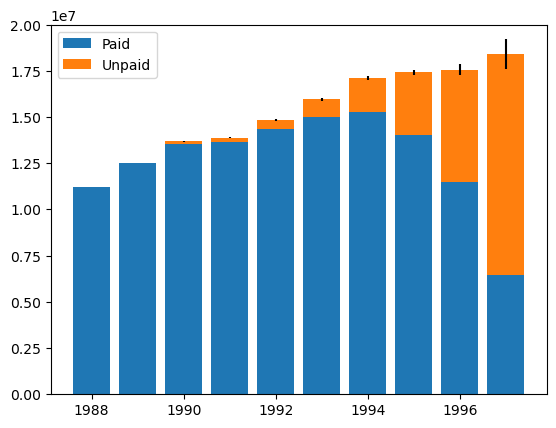

In [107]:
plt.bar(
    mack_mod.summary_.to_frame().index.year,
    mack_mod.summary_.to_frame()["Latest"],
    label="Paid",
)
plt.bar(
    mack_mod.summary_.to_frame().index.year,
    mack_mod.summary_.to_frame()["IBNR"],
    bottom=mack_mod.summary_.to_frame()["Latest"],
    yerr=mack_mod.summary_.to_frame()["Mack Std Err"],
    label="Unpaid",
)
plt.legend(loc="upper left")
plt.ylim(0, 20000000)

In [108]:
mack_mod.summary_

Latest          IBNR      Ultimate   Mack Std Err
1988  11203949.0           NaN  1.120395e+07            NaN
1989  12492899.0  3.618623e+04  1.252909e+07    7612.690223
1990  13559557.0  1.192173e+05  1.367877e+07   29904.992210
1991  13642414.0  2.424152e+05  1.388483e+07   34341.474494
1992  14347271.0  4.849332e+05  1.483220e+07   38638.874014
1993  15005138.0  9.466176e+05  1.595176e+07   58393.849416
1994  15249326.0  1.854279e+06  1.710361e+07   94894.193048
1995  14010098.0  3.418299e+06  1.742840e+07  139872.884208
1996  11473912.0  6.094599e+06  1.756851e+07  276854.086589
1997   6451896.0  1.196771e+07  1.841960e+07  793559.126941

We can also simulate the (assumed) normally distributed IBNR with `np.random.normal()`.

(array([  2.,   2.,   2.,   4.,   9.,  14.,  17.,  39.,  47.,  59.,  90.,
        144., 159., 202., 288., 325., 388., 430., 507., 537., 604., 642.,
        650., 615., 590., 546., 534., 507., 429., 357., 323., 233., 196.,
        171., 113.,  73.,  51.,  36.,  26.,  22.,   5.,   3.,   2.,   2.,
          2.,   0.,   2.,   0.,   0.,   1.]),
 array([21838558.78255578, 21984792.64512774, 22131026.5076997 ,
        22277260.37027166, 22423494.23284362, 22569728.09541558,
        22715961.95798754, 22862195.82055949, 23008429.68313145,
        23154663.54570341, 23300897.40827537, 23447131.27084733,
        23593365.13341929, 23739598.99599125, 23885832.85856321,
        24032066.72113517, 24178300.58370713, 24324534.44627909,
        24470768.30885104, 24617002.171423  , 24763236.03399497,
        24909469.89656692, 25055703.75913888, 25201937.62171084,
        25348171.4842828 , 25494405.34685476, 25640639.20942672,
        25786873.07199868, 25933106.93457064, 26079340.7971426 ,
        

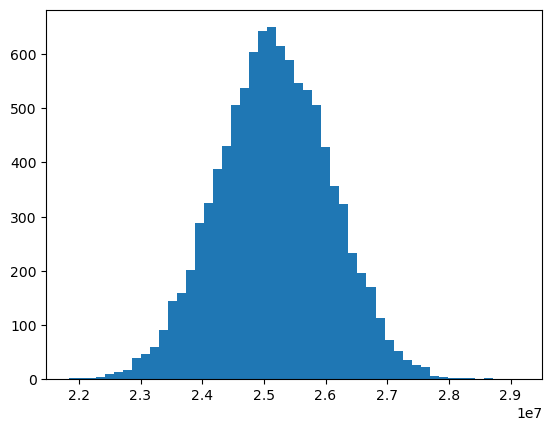

In [109]:
ibnr_mean = mack_mod.ibnr_.sum()
ibnr_sd = mack_mod.total_mack_std_err_.values[0, 0]
n_trials = 10000

np.random.seed(2024)
dist = np.random.normal(ibnr_mean, ibnr_sd, size=n_trials)

plt.hist(dist, bins=50)

## ODP Bootstrap Model

The `chainladder.MackChainladder()` focuses on a regression framework for determining the variability of reserve estimates. An alternative approach is to use the statistical bootstrapping, or sampling from a triangle with replacement to simulate new triangles, which is what `chainladder.BootstrapODPSample()` does.

Bootstrapping imposes less model constraints than the `chainladder.MackChainladder()`, which allows for greater applicability in different scenarios. Sampling new triangles can be accomplished through the `chainladder.BootstrapODPSample()` estimator. This estimator will take a single triangle and simulate new ones from it. To simulate new triangles randomly from an existing triangle, we specify `n_sims` with how many triangles we want to simulate, and access the `resampled_triangles_` attribute to get the simulated triangles. Notice that the shape of `resampled_triangles_` matches `n_sims` at the first index.

In [110]:
samples = (
    cl.BootstrapODPSample(n_sims=10000)
    .fit(clrd_lob.sum()["CumPaidLoss"])
    .resampled_triangles_
)
samples

Triangle Summary
Valuation:             1997-12
Grain:                    OYDY
Shape:      (10000, 1, 10, 10)
Index:                   [LOB]
Columns:         [CumPaidLoss]

In [111]:
samples = (
    cl.BootstrapODPSample(n_sims=10000)
    .fit(clrd_lob.sum()["CumPaidLoss"])
    .resampled_triangles_
)
samples

Triangle Summary
Valuation:             1997-12
Grain:                    OYDY
Shape:      (10000, 1, 10, 10)
Index:                   [LOB]
Columns:         [CumPaidLoss]

Alternatively, we could use `chainladder.BootstrapODPSample()` to transform our triangle into a resampled set.

The notion of the ODP Bootstrap is that as our simulations approach infinity, we should expect our mean simulation to converge on the basic Chainladder estimate of reserves.

Let’s apply the basic Chainladder to our original triangle and also to our simulated triangles to see whether this holds true.

In [112]:
ibnr_cl = cl.Chainladder().fit(clrd["CumPaidLoss"].sum()).ibnr_.sum()
ibnr_bootstrap = cl.Chainladder().fit(samples).ibnr_.sum("origin").mean()

print(
    "Chainladder's IBNR estimate:",
    ibnr_cl,
)
print(
    "BootstrapODPSample's mean IBNR estimate:",
    ibnr_bootstrap,
)
print("Difference $:", ibnr_cl - ibnr_bootstrap)
print("Difference %:", abs(ibnr_cl - ibnr_bootstrap) / ibnr_cl)

Chainladder's IBNR estimate: 25164252.77609498
BootstrapODPSample's mean IBNR estimate: 25174827.282087803
Difference $: -10574.505992822349
Difference %: 0.0004202193519081044


The difference is small, as expected.

The last thing we will do, is to compare `chainladder.MackChainladder()` against `chainladder.BootstrapODPSample()`. Recall the Mack model is stored as `mack_mod`. We can get its total `ibnr_` and its standard error with `.total_mack_std_err_`. We then simulate 10,000 trials to form a Mack stimulated total IBNR.

In [113]:
ibnr_mean = mack_mod.ibnr_.sum()
ibnr_sd = mack_mod.total_mack_std_err_.values[0, 0]

np.random.seed(2024)
dist = np.random.normal(ibnr_mean, ibnr_sd, size=10000)

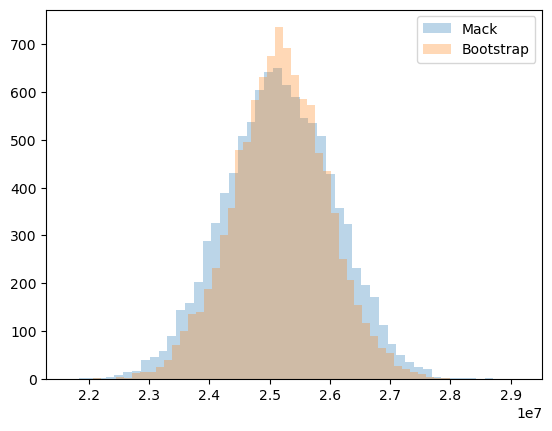

In [114]:
plt.hist(dist, bins=50, label="Mack", alpha=0.3)
plt.hist(
    cl.Chainladder().fit(samples).ibnr_.sum("origin").to_frame(origin_as_datetime=True),
    bins=50,
    label="Bootstrap",
    alpha=0.3,
)
plt.legend(loc="upper right")

# Data Preparation Considerations

Even though data preparation is probably the first thing that the practicing actuary, we decided to put the discussion here as it will be the piece that will vary between users the most. Here we offer a couple of thought ideas and make suggestions on things that you might want to consider.

## Triangle Data Format

One of the most commonly asked questions is that if the data needs to be in the tabular long format as opposed to the more commonly used triangle format when we are loading the data for use.

Unfortunately, the `chainladder` package requires the data to be in long form.

Suppose you have a wide triangle.

In [115]:
df_raa = cl.load_sample("raa").to_frame()
df_raa

12       24       36       48       60       72       84   \
1981-01-01  5012.0   8269.0  10907.0  11805.0  13539.0  16181.0  18009.0   
1982-01-01   106.0   4285.0   5396.0  10666.0  13782.0  15599.0  15496.0   
1983-01-01  3410.0   8992.0  13873.0  16141.0  18735.0  22214.0  22863.0   
1984-01-01  5655.0  11555.0  15766.0  21266.0  23425.0  26083.0  27067.0   
1985-01-01  1092.0   9565.0  15836.0  22169.0  25955.0  26180.0      NaN   
1986-01-01  1513.0   6445.0  11702.0  12935.0  15852.0      NaN      NaN   
1987-01-01   557.0   4020.0  10946.0  12314.0      NaN      NaN      NaN   
1988-01-01  1351.0   6947.0  13112.0      NaN      NaN      NaN      NaN   
1989-01-01  3133.0   5395.0      NaN      NaN      NaN      NaN      NaN   
1990-01-01  2063.0      NaN      NaN      NaN      NaN      NaN      NaN   

                96       108      120  
1981-01-01  18608.0  18662.0  18834.0  
1982-01-01  16169.0  16704.0      NaN  
1983-01-01  23466.0      NaN      NaN  
1984-01-01      NaN      NaN      NaN  
1985-01-01      NaN      NaN      NaN  
1986-01-01      NaN      NaN      NaN  
1987-01-01      NaN      NaN      NaN  
1988-01-01      NaN      NaN      NaN  
1989-01-01      NaN      NaN      NaN  
1990-01-01      NaN      NaN      NaN

You can use `pandas` to `.unstack()` the data into the wide long format.

In [116]:
df_raa = df_raa.unstack().dropna().reset_index()
df_raa.columns = ["age", "origin", "values"]
df_raa.head(10)

age     origin  values
0   12 1981-01-01  5012.0
1   12 1982-01-01   106.0
2   12 1983-01-01  3410.0
3   12 1984-01-01  5655.0
4   12 1985-01-01  1092.0
5   12 1986-01-01  1513.0
6   12 1987-01-01   557.0
7   12 1988-01-01  1351.0
8   12 1989-01-01  3133.0
9   12 1990-01-01  2063.0

Next, we will need a valuation column (think Schedule P style triangle).

In [117]:
df_raa["valuation"] = (df_raa["origin"].dt.year + df_raa["age"] / 12 - 1).astype(int)
df_raa.head(10)

age     origin  values  valuation
0   12 1981-01-01  5012.0       1981
1   12 1982-01-01   106.0       1982
2   12 1983-01-01  3410.0       1983
3   12 1984-01-01  5655.0       1984
4   12 1985-01-01  1092.0       1985
5   12 1986-01-01  1513.0       1986
6   12 1987-01-01   557.0       1987
7   12 1988-01-01  1351.0       1988
8   12 1989-01-01  3133.0       1989
9   12 1990-01-01  2063.0       1990

Now, we are ready to load it into the `chainladder` package!

In [118]:
cl.Triangle(
    df_raa, origin="origin", development="valuation", columns="values", cumulative=True
)

12       24       36       48       60       72       84       96       108      120
1981  5012.0   8269.0  10907.0  11805.0  13539.0  16181.0  18009.0  18608.0  18662.0  18834.0
1982   106.0   4285.0   5396.0  10666.0  13782.0  15599.0  15496.0  16169.0  16704.0      NaN
1983  3410.0   8992.0  13873.0  16141.0  18735.0  22214.0  22863.0  23466.0      NaN      NaN
1984  5655.0  11555.0  15766.0  21266.0  23425.0  26083.0  27067.0      NaN      NaN      NaN
1985  1092.0   9565.0  15836.0  22169.0  25955.0  26180.0      NaN      NaN      NaN      NaN
1986  1513.0   6445.0  11702.0  12935.0  15852.0      NaN      NaN      NaN      NaN      NaN
1987   557.0   4020.0  10946.0  12314.0      NaN      NaN      NaN      NaN      NaN      NaN
1988  1351.0   6947.0  13112.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN
1989  3133.0   5395.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN
1990  2063.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN

## Incremental vs Cumulative Triangles

While actuaries are working with cumulative triangles more often, cumulative triangles are actually inferior to incremental triangles when they come to data storage and processing. This is because incremental triangles only have to contain information on any differences, whereas cumulative triangles contain all the information that the incremental triangle has, but will take up more storage space since a data point needs to exist for all valuation period.

Consider the `prism` dataset, which is a claim level dataset with over 13,000 triangles.

In [119]:
prism = cl.load_sample("prism")
prism

Triangle Summary
Valuation:                                            2017-12
Grain:                                                   OMDM
Shape:                                   (34244, 4, 120, 120)
Index:      [ClaimNo, Line, Type, ClaimLiability, Limit, D...
Columns:     [reportedCount, closedPaidCount, Paid, Incurred]

We see that the dataset has a shape of `(34244, 4, 120, 120)` with its size being only approximately `2.8M`.

In [120]:
prism.values

<COO: shape=(34244, 4, 120, 120), dtype=float64, nnz=121178, fill_value=nan>

But converting the dataset into cumulative triangle, the size is significantlly larger, by nearly 80 times!

In [121]:
prism.incr_to_cum().values

<COO: shape=(34244, 4, 120, 120), dtype=float64, nnz=5750047, fill_value=nan>

## Sparse Triangles

By default, the `chainladder.Triangle()` is a wrapper around a `numpy` array. `numpy` is optimized for high performance, and this allows `chainladder` to achieve decent computational speeds. However, despite being fast, `numpy` can become memory inefficient with triangle data because triangles are inherently sparse (when memory is being allocated yet no data is stored). This is because the lower half of an incomplete triangle is generally blank and that means about 50% of an array size is allocated yet wasted to store nothing. As we include granular index and column values in our Triangle, the sparsity of the triangle increases, further consuming RAM unnecessarily. `chainladder` automatically eliminates this extraneous consumption of memory by resorting to a sparse array representation when the `chainladder.Triangle()` becomes sufficiently large. Unless you are an expert or are running into RAM issues, it will be uncommon for an end user to have to make these adjustments manually.

## Claim-Level Data

The sparse representation of triangles allows for substantially more data to be pushed through `chainladder`. This gives us some nice capabilities that we would not otherwise be able to do with aggregated data.

This will allow you to drill into the individual claim makeup of any cell in our `chainladder.Triangle()`. 

For example, we can look at all the claims happened in January of 2017, at age 12.

In [122]:
claims = prism[prism.origin == "2017-01"][prism.development == 12].to_frame(
    origin_as_datetime=True
)
claims[abs(claims).sum(axis="columns") != 0].reset_index()

ClaimNo  Line Type  ClaimLiability    Limit  Deductible  reportedCount  \
0     38147  Auto   PD            True  20000.0        1000            1.0   
1     38157  Auto   PD            True  20000.0        1000            1.0   
2     38163  Auto   PD            True   8000.0        1000            1.0   
3     38192  Auto   PD            True  20000.0        1000            1.0   
4     38197  Auto   PD            True  20000.0        1000            1.0   
5     38215  Auto   PD            True   8000.0        1000            1.0   
6     38221  Auto   PD            True  20000.0        1000            1.0   
7     38228  Auto   PD            True  20000.0        1000            1.0   
8     38263  Auto   PD            True  15000.0        1000            1.0   
9     38307  Auto   PD            True  15000.0        1000            1.0   
10    38367  Auto   PD            True  20000.0        1000            1.0   
11    38373  Auto   PD            True  20000.0        1000            1.0   
12    38377  Auto   PD            True  20000.0        1000            1.0   
13    38393  Auto   PD            True   8000.0        1000            1.0   
14    38396  Auto   PD            True   8000.0        1000            1.0   
15    38455  Auto   PD            True  20000.0        1000            1.0   
16    38457  Auto   PD            True  15000.0        1000            1.0   
17    38460  Auto   PD            True  15000.0        1000            1.0   

    closedPaidCount          Paid      Incurred  
0               1.0  14540.067710  14540.067710  
1               1.0   3873.094721   3873.094721  
2               1.0   7000.000000   7000.000000  
3               1.0   6451.718210   6451.718210  
4               1.0  18222.149160  18222.149160  
5               1.0   7000.000000   7000.000000  
6               1.0  17844.211120  17844.211120  
7               1.0  10262.441970  10262.441970  
8               1.0  14000.000000  14000.000000  
9               1.0  11901.151660  11901.151660  
10              1.0   5207.251558   5207.251558  
11              1.0   4900.780565   4900.780565  
12              1.0   5741.776419   5741.776419  
13              1.0   7000.000000   7000.000000  
14              1.0   7000.000000   7000.000000  
15              1.0   9927.351224   9927.351224  
16              1.0   7874.879070   7874.879070  
17              1.0   3125.840672   3125.840672

Or that if we want to cop large losses or create an excess triangle on the fly.

In [123]:
prism["Capped 100k Paid"] = cl.minimum(prism["Paid"], 100000)
prism["Excess 100k Paid"] = prism["Paid"] - prism["Capped 100k Paid"]

We can take this even further, we can create claim-level IBNR estimates.

But first, let's fit a simple Chainladder model using the aggregated data.

In [124]:
agg_data = prism.sum()[["Paid", "reportedCount"]]
cl_mod = cl.Chainladder().fit(agg_data)

In [126]:
cl_ults = cl_mod.predict(prism[["Paid", "reportedCount"]]).ultimate_
cl_ults

Triangle Summary
Valuation:                                            2261-12
Grain:                                                   OMDM
Shape:                                     (34244, 2, 120, 1)
Index:      [ClaimNo, Line, Type, ClaimLiability, Limit, D...
Columns:                                [Paid, reportedCount]

Let’s try a Bornhuetter-Ferguson method as well. We will infer an a priori severity from our chainladder model, `cl_mod` above.

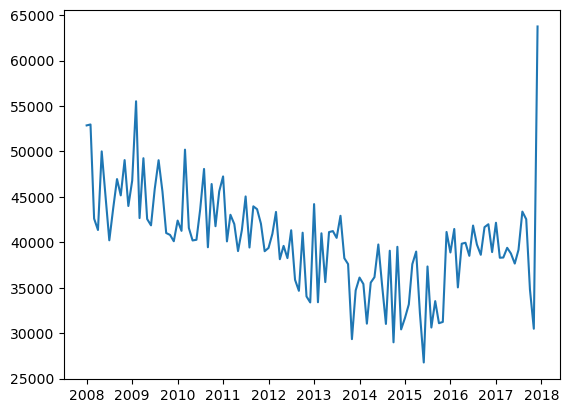

In [127]:
plt.plot(
    (cl_mod.ultimate_["Paid"] / cl_mod.ultimate_["reportedCount"]).to_frame(),
)

There are some trends in the severity, but $40,000 doesn't look like a bad a priori (at least for the last two eyears or so, between 2016 and 2018).

Now, let’s fit an aggregate Bornhuetter-Ferguson model. Like the Chainladder example, we fit the model in aggregate (summing all claims) to create a stable model from which we can generate granular predictions. We will use our Chainladder ultimate claim counts as our sample_weight (exposure) for the Bornhuetter-Ferguson method. Essentially, we are saying for each `reportedCount`, we will assume `40000` each of ultimate severity as the a priori.

In [129]:
paid_bf = cl.BornhuetterFerguson(apriori=40000).fit(
    X=prism["Paid"].sum().incr_to_cum(), sample_weight=cl_ults["reportedCount"].sum()
)

We can now create claim-level Bornhuetter-Ferguson predictions using our claim-level Triangle. 

In [131]:
paid_bf.predict(
    prism["Paid"].incr_to_cum(), sample_weight=cl_ults["reportedCount"]
).ultimate_

Triangle Summary
Valuation:                                            2261-12
Grain:                                                   OMDM
Shape:                                     (34244, 1, 120, 1)
Index:      [ClaimNo, Line, Type, ClaimLiability, Limit, D...
Columns:                                               [Paid]

## Consolidating Exposure and Loss Data

Very often, actuaries will use both exposure data and loss data together, instead of just studying and analyzing loss data by itself. Because of this, the practitioner will need to figure out a way to consolidate the data together into a single dataset. This is often more challenging in practice as one would have to first worry about pulling data from difference data systems, and consolidating them together after.

When it comes to consolidating the data, you most likely will choose one of these two options.

### Exposure and Loss Data as Columns

The `clrd` dataset is prepared this way, where exposure and loss data sit side-by side.

In [138]:
cl.load_sample("clrd").to_frame().reset_index()

GRNAME      LOB     origin  development  IncurLoss  \
0            Adriatic Ins Co  othliab 1995-01-01           12        8.0   
1            Adriatic Ins Co  othliab 1995-01-01           24       11.0   
2            Adriatic Ins Co  othliab 1995-01-01           36        7.0   
3            Adriatic Ins Co  othliab 1996-01-01           12       40.0   
4            Adriatic Ins Co  othliab 1996-01-01           24       40.0   
...                      ...      ...        ...          ...        ...   
33084             Yel Co Ins  comauto 1995-01-01           36      282.0   
33085             Yel Co Ins  comauto 1996-01-01           12      707.0   
33086             Yel Co Ins  comauto 1996-01-01           24      699.0   
33087             Yel Co Ins  comauto 1997-01-01           12      698.0   
33088  Zurich Ins (Guam) Inc   wkcomp 1997-01-01           12        NaN   

       CumPaidLoss  BulkLoss  EarnedPremDIR  EarnedPremCeded  EarnedPremNet  
0              NaN       8.0          139.0            131.0            8.0  
1              NaN       4.0          139.0            131.0            8.0  
2              3.0       4.0          139.0            131.0            8.0  
3              NaN      40.0          410.0            359.0           51.0  
4              NaN      40.0          410.0            359.0           51.0  
...            ...       ...            ...              ...            ...  
33084         37.0     102.0          403.0              NaN          403.0  
33085         40.0     495.0          996.0              NaN          996.0  
33086         60.0     502.0          996.0              NaN          996.0  
33087         25.0     506.0          996.0              NaN          996.0  
33088          NaN       NaN           55.0              NaN           55.0  

[33089 rows x 10 columns]